# Movie  Analysis Project

## Introduction

This project aims to analyze movie data from various sources to provide data-driven insights for a company launching a new movie studio. The goal is to identify the types of films that are most likely to perform well at the box office. This analysis will help the company decide what kind of movies to create.

## Business Problem

Our company is venturing into the creation of original video content, specifically a new movie studio. However, the company lacks experience in the movie production industry. Therefore, this analysis will be a data-driven exploration into what types of films are currently achieving success at the box office and translating that into actionable recommendations for the new studio.

## Data Sources

The following datasets are used in this analysis:

*   `bom.movie_gross.csv`: Box office gross revenue data from Box Office Mojo.
*   `tn.movie_budgets.csv`: Movie budget data from The Numbers.
*   `tmdb.movies.csv`: Movie metadata (including genres, cast, and release date) from The Movie Database (TMDB).
*   `rt.movie_info.tsv`: Movie information and ratings from Rotten Tomatoes.
*   `rt.reviews.tsv`: Movie reviews from Rotten Tomatoes.
*  `im.db`: Movie information and ratings from the IMDB database

## Analysis Focus
This analysis will focus on addressing these key questions:

1.  **Financial Performance:**
    - Which genres are currently the most financially successful (highest revenue and profit)?
    - What is the average return on investment (ROI) for different genres?
    - Does a higher budget guarantee higher revenue?
    - What is the relationship between production budget and box office gross?
    - Are there budget levels that yield the best return for specific genres?
    - Which months are better for launching a movie? Do certain types of movies do better in specific months?

2.  **Popularity:**
    - Which genres are most popular among audiences (based on popularity metrics)?
    - What is the correlation between popularity and financial success?

3.  **Critical Acclaim & Audience Sentiment:**
    - Which genres tend to receive the highest critical ratings and positive reviews?
    - Is there a correlation between audience sentiment (from review text) and financial success?
    - How do ratings differ between Rotten Tomatoes, TMDB, or any other rating source?
    - Are there any inconsistencies across ratings?
    - Are there some movies that are more polarizing than others (have widely different reviews)?

4.  **Influence of Key Personnel:**
    - Which directors or actors are associated with high-grossing movies?
    - Are there some directors or actors that are strongly associated with one genre?
    - Are there any common collaborations between directors and actors in high-performing films?


The goal is to provide data-driven recommendations regarding which types of movies the new studio should prioritize, taking into consideration the financial performance, the popularity of those movies, and also taking into consideration the talent involved.

In [73]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats
%matplotlib inline
import ast # For our genre
import sqlite3
from scipy.stats import kruskal

In [7]:
# Load the data
df_bom = pd.read_csv('Data/bom.movie_gross.csv')
df_tn = pd.read_csv('Data/tn.movie_budgets.csv')
df_tmdb = pd.read_csv('Data/tmdb.movies.csv')
df_rt_info = pd.read_table('Data/rt.movie_info.tsv')
df_rt_reviews = pd.read_table('Data/rt.reviews.tsv', encoding = 'latin-1')

In [8]:
conn = sqlite3.connect('Data/im.db')
cursor = conn.cursor()

## Getting General overview of our datasets

### The Box office Mojo (BOM) dataset

In [9]:
df_bom

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [10]:
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


For most columns they have relatively well populated except foreign_gross. The foreign_gross column is object type we will have to convert it into float64.

In [11]:
df_bom.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


The numbers for the money movie are extremely huge for us to make meaning of the statistical measure. we might consider rounding them off to the nearest million.

In [12]:
df_bom['studio'].unique()

array(['BV', 'WB', 'P/DW', 'Sum.', 'Par.', 'Uni.', 'Fox', 'Wein.', 'Sony',
       'FoxS', 'SGem', 'WB (NL)', 'LGF', 'MBox', 'CL', 'W/Dim.', 'CBS',
       'Focus', 'MGM', 'Over.', 'Mira.', 'IFC', 'CJ', 'NM', 'SPC', 'ParV',
       'Gold.', 'JS', 'RAtt.', 'Magn.', 'Free', '3D', 'UTV', 'Rela.',
       'Zeit.', 'Anch.', 'PDA', 'Lorb.', 'App.', 'Drft.', 'Osci.', 'IW',
       'Rog.', nan, 'Eros', 'Relbig.', 'Viv.', 'Hann.', 'Strand', 'NGE',
       'Scre.', 'Kino', 'Abr.', 'CZ', 'ATO', 'First', 'GK', 'FInd.',
       'NFC', 'TFC', 'Pala.', 'Imag.', 'NAV', 'Arth.', 'CLS', 'Mont.',
       'Olive', 'CGld', 'FOAK', 'IVP', 'Yash', 'ICir', 'FM', 'Vita.',
       'WOW', 'Truly', 'Indic.', 'FD', 'Vari.', 'TriS', 'ORF', 'IM',
       'Elev.', 'Cohen', 'NeoC', 'Jan.', 'MNE', 'Trib.', 'Rocket',
       'OMNI/FSR', 'KKM', 'Argo.', 'SMod', 'Libre', 'FRun', 'WHE', 'P4',
       'KC', 'SD', 'AM', 'MPFT', 'Icar.', 'AGF', 'A23', 'Da.', 'NYer',
       'Rialto', 'DF', 'KL', 'ALP', 'LG/S', 'WGUSA', 'MPI', 'RTWC', 'FIP

In [13]:
df_bom['studio'].unique().size

258

Studio will have to given full name where it is abbreviate to make it easier to understand.

### The tn (The Numbers) dataset

In [14]:
df_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [15]:
df_tn['id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [16]:
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The dataset from the numbers doesn't have any null value that we can see so far. It has the issue of wrong data types for release_date, Production_Budget, Domestic_gross and Worldwide_gross columns and they will have to be convert to correct type.

In [17]:
df_tn.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


Describe function is result that much because the numeric columns are in object type but even the we have seen the number we are dealing with are extremely big so we are deciding to we go with the same route as the other dataset and then will inspect further.

### The tmdb (The Movie DB) dataset

In [18]:
df_tmdb

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [19]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


# Data Cleaning

### The imdb dataset

The dataset is an sqlite database, with data drom imdb.

In [20]:
# Getting the list of all the tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]
tables

['movie_basics',
 'directors',
 'known_for',
 'movie_akas',
 'movie_ratings',
 'persons',
 'principals',
 'writers']

In [21]:
for table in tables:
    print(f"Table: {table}")
    df = pd.read_sql(f"SELECT * FROM {table};", conn)
    df.info()
    print("\n" + "="*40 + "\n")

Table: movie_basics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Table: directors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


Table: known_for
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638260 entries, 0 to 1638259
Data

In [22]:
# loading the movie_basics table
movie_basics = pd.read_sql("""SELECT *FROM movie_basics;""",conn)

# loading the movie_ratings table
movie_ratings = pd.read_sql("""SELECT *FROM movie_ratings;""",conn)

In [23]:
# Inner join merge movie_basics and movie_ratings
df_imdb = pd.merge(movie_basics, movie_ratings, on = ['movie_id'], how = 'inner')
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 5.1+ MB


In [24]:
# Rename column
df_imdb = df_imdb.rename(columns = {'primary_title':'title'})
df_imdb.head()

,movie_id,title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [25]:
df_imdb.dropna(inplace=True)

In [26]:
# Confirming if the null have now been dropped
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65720 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   title            65720 non-null  object 
 2   original_title   65720 non-null  object 
 3   start_year       65720 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           65720 non-null  object 
 6   averagerating    65720 non-null  float64
 7   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [27]:
# Get the top 30% of movies by rating
top_30_percent_threshold = int(len(df_imdb) * 0.3)
df_top_movies = df_imdb.iloc[:top_30_percent_threshold]

# Expand the genres column into individual genres
genre_counts = (
    df_top_movies['genres']
    .str.split(',')
    .explode()  # Splits and expands the genres into individual rows
    .value_counts()
)
genre_counts

Drama          8968
Comedy         4969
Documentary    4414
Thriller       2480
Horror         2172
Action         2114
Romance        1879
Crime          1509
Adventure      1246
Biography      1179
Family          945
Mystery         899
History         859
Sci-Fi          717
Fantasy         676
Music           599
Animation       499
Sport           314
War             249
Musical         211
News            205
Western          86
Reality-TV        3
Game-Show         1
Name: genres, dtype: int64

In [28]:
directors_table = pd.read_sql("""SELECT * FROM directors;""", conn)
directors_table

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [29]:
persons_table = pd.read_sql("""SELECT * FROM persons;""", conn)
persons_table

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [30]:
# Merge directors and persons table to get director details
directors_with_details = pd.merge(directors_table, persons_table, on='person_id', how='inner')

# Filter to only include alive directors (death_year is NaN)
alive_directors = directors_with_details[directors_with_details['death_year'].isna()]

# Merge with the movies data to associate directors with movies
alive_directors_movies = pd.merge(alive_directors, df_imdb, on='movie_id', how='inner')

# Count the number of movies per director
director_movie_counts = alive_directors_movies.groupby('primary_name').size().reset_index(name='movie_count')

# Sort by movie count in descending order
director_movie_counts = director_movie_counts.sort_values(by='movie_count', ascending=False)

top_6_directors = director_movie_counts.head(6)
top_6_directors

,primary_name,movie_count
43658,Shane Ryan,155
47953,Tony Newton,130
41360,Ruben Rodriguez,129
9523,Corey Norman,107
20890,Jason Impey,102
14680,Evan Marlowe,100


In [31]:
# Calculate the average ratings for each director
director_avg_ratings = (
    alive_directors_movies.groupby('primary_name')['averagerating']
    .mean()
    .reset_index(name='avg_rating')
)

# Merge the average ratings into the top_6_directors DataFrame
top_6_directors = pd.merge(top_6_directors, director_avg_ratings, on='primary_name', how='inner').reset_index(drop=True)
top_6_directors

,primary_name,movie_count,avg_rating
0,Shane Ryan,155,5.626452
1,Tony Newton,130,4.785385
2,Ruben Rodriguez,129,6.079845
3,Corey Norman,107,6.017757
4,Jason Impey,102,5.158824
5,Evan Marlowe,100,6.403000


In [32]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65720 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   title            65720 non-null  object 
 2   original_title   65720 non-null  object 
 3   start_year       65720 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           65720 non-null  object 
 6   averagerating    65720 non-null  float64
 7   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


## The Box Office Mojo (BOM) dataset

We are going to begin our cleaning with the The Box Office Mojo. 

The following are the Action we are going to take:

**1. Fill the null values in foreign gross column with zero**
 - The rationale for this is we are going with the assumption that the movies that don't have foreign gross have not been sold internationally 

**2. Drop null values in domestic and studio.**
 - They are few as a result the deletion has no impact on our analysis.
 
**3. Feature Engineer: Create Worldwide gross.**
 - We will do this by adding domestic and foreign gross. 
 
**4. Feature Engineer: create studio names**
 - We will match studio name abbreation to their corresponding studio names.
 
**5. We round off our currency columns to the nearest million**
 - This is to make our data more readable and easier to work with.
 
**6. We are going to filter our dataset.**
   - We will use worldwide gross to remove movies that made less than a million
   
**7. Standadization.**
   - Title column in title format

In [33]:
# Before cleaning
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [34]:
# Fill null columns in the foreign_gross column, with 0
df_bom['foreign_gross'].fillna(0, inplace=True)

In [35]:
# Drop null records in domestic_gross and studio columns
df_bom.dropna(subset=['domestic_gross', 'studio'], inplace=True)

In [36]:
# Remove commas, and change the datatype of the column to be float
df_bom['foreign_gross'] = df_bom['foreign_gross'].replace(',', '', regex=True).astype(float)

In [37]:
# Feature engineer a worlswide_gross column
df_bom['worldwide_gross'] = df_bom['domestic_gross'] + df_bom['foreign_gross']

Sony Pictures refers to the broader production arm responsible for mainstream movies.
Sony Pictures Classics (SPC) is a subsidiary that specializes in independent films, documentaries, and arthouse productions.
Therefore here, we will combine Sony with SPC.

In [38]:
studio_map = {
    'BV': 'Buena Vista',
    'WB': 'Warner Bros.',
    'P/DW': 'Paramount/DreamWorks',
    'Sum.': 'Summit Entertainment',
    'Par.': 'Paramount Pictures',
    'Uni.': 'Universal Pictures',
    'Fox': '20th Century Fox',
    'Wein.': 'The Weinstein Company',
    'Sony': 'Sony Pictures',
    'FoxS': 'Fox Searchlight Pictures',
    'SGem': 'Screen Gems',
    'WB (NL)': 'Warner Bros. (New Line Cinema)',
    'LGF': 'Lionsgate Films',
    'MBox': 'Movie Box',
    'CL': 'Columbia Pictures',
    'W/Dim.': 'Walt Disney/Dimension Films',
    'CBS': 'CBS Films',
    'Focus': 'Focus Features',
    'MGM': 'Metro-Goldwyn-Mayer',
    'Over.': 'Overture Films',
    'Mira.': 'Miramax Films',
    'IFC': 'IFC Films',
    'CJ': 'CJ Entertainment',
    'NM': 'Newmarket Films',
    'SPC': 'Sony Pictures',  # Combine Sony Pictures, with Sony Pictures classic
    'ParV': 'Paramount Vantage',
    'Gold.': 'Goldwyn Films',
    'JS': 'Jerry Seinfeld Productions',
    'RAtt.': 'Roadside Attractions',
    'Magn.': 'Magnolia Pictures',
    'Free': 'Freestyle Releasing',
    '3D': '3D Entertainment',
    'UTV': 'UTV Motion Pictures',
    'Rela.': 'Relativity Media',
    'Zeit.': 'Zeitgeist Films',
    'Anch.': 'Anchor Bay Entertainment',
    'PDA': 'Picturehouse',
    'Lorb.': 'Lorber Films',
    'App.': 'Apparition',
    'Drft.': 'DraftHouse Films',
    'Osci.': 'Oscilloscope Laboratories',
    'IW': 'IndieWire Films',
    'Rog.': 'Rogue Pictures',
    'Eros': 'Eros International',
    'Relbig.': 'Reliance Big Entertainment',
    'Viv.': 'Vivendi Entertainment',
    'Hann.': 'Hannover House',
    'Strand': 'Strand Releasing',
    'NGE': 'Next Generation Entertainment',
    'Scre.': 'Screen Media Films',
    'Kino': 'Kino Lorber',
    'Abr.': 'Abramorama',
    'CZ': 'Czech Films',
    'ATO': 'ATO Pictures',
    'First': 'First Look Pictures',
    'GK': 'GK Films',
    'FInd.': 'Film Independent',
    'NFC': 'National Film Corporation',
    'TFC': 'The Film Collaborative',
    'Pala.': 'Paladin Films',
    'Imag.': 'Imagine Entertainment',
    'NAV': 'Navarre Corporation',
    'Arth.': 'Art House Films',
    'CLS': 'Classic Films',
    'Mont.': 'Montreal Films',
    'Olive': 'Olive Films',
    'CGld': 'Cineguild',
    'FOAK': 'Film on Air Kids',
    'IVP': 'Independent Video Producers',
    'Yash': 'Yash Raj Films',
    'ICir': 'International Circuit',
    'FM': 'Film Movement',
    'Vita.': 'Vitascope',
    'WOW': 'World of Wonder',
    'Truly': 'Truly Indie',
}

In [39]:
df_bom['studio_name'] = df_bom['studio'].map(studio_map).fillna('Unknown')

In [40]:
df_bom[['domestic_gross', 'foreign_gross', 'worldwide_gross']]

,domestic_gross,foreign_gross,worldwide_gross
0,415000000.0,652000000.0,1.067000e+09
1,334200000.0,691300000.0,1.025500e+09
2,296000000.0,664300000.0,9.603000e+08
3,292600000.0,535700000.0,8.283000e+08
4,238700000.0,513900000.0,7.526000e+08
...,...,...,...
3382,6200.0,0.0,6.200000e+03
3383,4800.0,0.0,4.800000e+03
3384,2500.0,0.0,2.500000e+03
3385,2400.0,0.0,2.400000e+03


In [41]:
df_bom = df_bom[df_bom['worldwide_gross'] >= 1]

In [42]:
df_bom['title'] = df_bom['title'].str.title()

In [43]:
# After cleaning 
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3356 non-null   object 
 1   studio           3356 non-null   object 
 2   domestic_gross   3356 non-null   float64
 3   foreign_gross    3356 non-null   float64
 4   year             3356 non-null   int64  
 5   worldwide_gross  3356 non-null   float64
 6   studio_name      3356 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 209.8+ KB


## Cleaning the numbers dataset

**1. Standadization**
 - Remove dollar sign in production_budget, domestic_gross and worldwide_gross columns
 - Rename movie column Title and as title format

**2. Conver colums into appropiate data types.**
 -  production_budget, domestic_gross and worldwide_gross columns to interger
 - release_data to datetime data type

**3. Round of our courrency collumns to the nearest millon**

**4. Feature Engineer**
 - Create Profit column by substructing production budget from worldwide_gross. we are operating on the assumption that the production budget was the actual cost and close enough.

**5. Drop id Column**

In [44]:
# Before cleaning
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [45]:
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    df_tn[col] = df_tn[col].replace('[\$,]', '', regex=True).astype(float)

In [46]:
df_tn['release_date'] = pd.to_datetime(df_tn['release_date'])

In [47]:
df_tn[['production_budget', 'domestic_gross', 'worldwide_gross']] 

,production_budget,domestic_gross,worldwide_gross
0,425000000.0,760507625.0,2.776345e+09
1,410600000.0,241063875.0,1.045664e+09
2,350000000.0,42762350.0,1.497624e+08
3,330600000.0,459005868.0,1.403014e+09
4,317000000.0,620181382.0,1.316722e+09
...,...,...,...
5777,7000.0,0.0,0.000000e+00
5778,6000.0,48482.0,2.404950e+05
5779,5000.0,1338.0,1.338000e+03
5780,1400.0,0.0,0.000000e+00


In [48]:
df_tn['profit'] = df_tn['worldwide_gross'] - df_tn['production_budget']

In [49]:
df_tn.rename(columns={'movie': 'title'}, inplace=True)
df_tn['title'] = df_tn['title'].str.title()

In [50]:
df_tn.drop(columns=['id'], inplace=True)

In [51]:
# After cleaning
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   title              5782 non-null   object        
 2   production_budget  5782 non-null   float64       
 3   domestic_gross     5782 non-null   float64       
 4   worldwide_gross    5782 non-null   float64       
 5   profit             5782 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 271.2+ KB


## Cleaning the tmdb dataset

**1. Drop 'unnamed' and 'id' columns**

**2. Match abbreviations with actual names**
 - column genre_id to their corresponding genre names for easy readability.
 - column original_language to their full languag

**3. convert release_date to datetime datatypes**

**4. Deal with outliers**

**5. subsetting for data relevant for the analysis.**
 - By using the vote_count column, we only select record where it is above 100

In [52]:
# Before cleaning
df_tmdb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [53]:
# Genre mapping dictionary
genre_mapping = {
    28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 80: "Crime", 99: "Documentary", 
    18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music", 
    9648: "Mystery", 10749: "Romance", 878: "Science Fiction", 10770: "TV Movie", 53: "Thriller", 
    10752: "War", 37: "Western"
}

# Function to map genre IDs to names
def map_genres(ids):
    ids_list = ast.literal_eval(ids)  # Convert string representation of list to actual list
    return ", ".join([genre_mapping.get(id, "Unknown") for id in ids_list])

# Create the new column with genres
df_tmdb['genres'] = df_tmdb['genre_ids'].apply(map_genres)
df_tmdb

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Fantasy, Family"
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Fantasy, Adventure, Animation, Family"
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Adventure, Action, Science Fiction"
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"Animation, Comedy, Family"
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Science Fiction, Adventure"
...,...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1,"Horror, Drama"
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1,"Drama, Thriller"
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1,"Fantasy, Action, Adventure"
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,"Family, Adventure, Action"


In [54]:
# Drop the unnecessary columns
df_tmdb = df_tmdb.drop(columns=['Unnamed: 0', 'genre_ids', 'original_language', 'original_title'])

# Convert release_date to datetime format
df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors='coerce')

In [55]:
language_map = {
    'en': 'English',
    'fr': 'French',
    'es': 'Spanish',
    'ru': 'Russian',
    'ja': 'Japanese',
    'de': 'German',
    'zh': 'Chinese',
    'ko': 'Korean',
    'hi': 'Hindi',
    'it': 'Italian',
    'pt': 'Portuguese',
    'ar': 'Arabic',
    'tr': 'Turkish',
    'nl': 'Dutch',
    'sv': 'Swedish',
    'da': 'Danish',
    'no': 'Norwegian',
    'fi': 'Finnish',
    'pl': 'Polish',
    'el': 'Greek'
}

Checking for outliers

c:\Users\Administrator\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='popularity'>

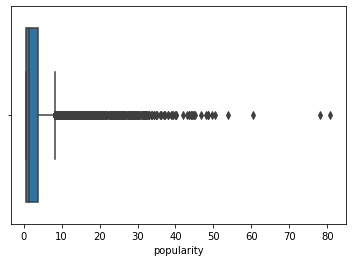

In [56]:
# Check the boxplot
sns.boxplot(df_tmdb['popularity'])

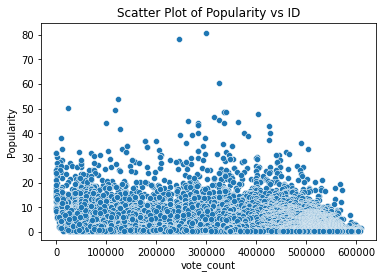

In [57]:
# Create a scatter plot of popularity column

sns.scatterplot(x=df_tmdb['id'], y=df_tmdb['popularity'])
plt.title('Scatter Plot of Popularity vs ID')
plt.xlabel('vote_count')
plt.ylabel('Popularity')
plt.show()

In [58]:
popularity_threshold = df_tmdb['popularity'].quantile(0.995)
df_tmdb = df_tmdb[df_tmdb['popularity'] <= popularity_threshold]

In [59]:
df_tmdb = df_tmdb[df_tmdb['vote_count'] > 100]

In [60]:
# Determine the 70th percentile of popularity
popularity_threshold = df_tmdb['popularity'].quantile(0.7)

# Filter to get the top 30% most popular movies
top_30_percent = df_tmdb[df_tmdb['popularity'] >= popularity_threshold]

# Expand the genres column to separate entries and clean spaces
expanded_genres = top_30_percent['genres'].str.split(',').explode().str.strip()

# Count the occurrences of each genre
genre_counts = expanded_genres.value_counts()
top_10_genres =  genre_counts.head(10)
top_10_genres

Drama              439
Action             352
Thriller           348
Comedy             300
Adventure          231
Crime              170
Science Fiction    161
Horror             140
Fantasy            136
Family             129
Name: genres, dtype: int64

In [61]:
# After cleaning
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3536 entries, 7 to 24546
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            3536 non-null   int64         
 1   popularity    3536 non-null   float64       
 2   release_date  3536 non-null   datetime64[ns]
 3   title         3536 non-null   object        
 4   vote_average  3536 non-null   float64       
 5   vote_count    3536 non-null   int64         
 6   genres        3536 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 221.0+ KB


In [62]:
###

In [63]:
# Selecting those with higher vote count of at least 100
df_tmdb_filtered = df_tmdb[df_tmdb['vote_count'] > 100]
df_tmdb_filtered.shape

(3536, 7)

In [64]:
#df_tmdb['original_language'].value_counts()

We can observe id column. These are ids given to the movies might come in handy if other dataset label movies with the same kind of ids.

In [65]:
df_tmdb

,id,popularity,release_date,title,vote_average,vote_count,genres
7,10193,24.445,2010-06-17,Toy Story 3,7.7,8340,"Animation, Family, Comedy"
8,20352,23.673,2010-07-09,Despicable Me,7.2,10057,"Animation, Family, Comedy"
9,38055,22.855,2010-11-04,Megamind,6.8,3635,"Animation, Action, Comedy, Family, Science Fic..."
10,863,22.698,1999-11-24,Toy Story 2,7.5,7553,"Animation, Comedy, Family"
11,12155,22.020,2010-03-05,Alice in Wonderland,6.6,8713,"Family, Fantasy, Adventure"
...,...,...,...,...,...,...,...
24462,503314,6.868,2019-01-16,Dragon Ball Super: Broly,7.4,721,"Action, Animation, Fantasy, Adventure, Comedy,..."
24469,416186,6.823,2018-04-20,Godard Mon Amour,6.8,160,"Drama, Romance, Comedy"
24472,531949,6.794,2018-07-20,Father of the Year,5.3,235,Comedy
24505,489430,6.553,2018-09-21,Terrified,6.4,111,Horror


In [66]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3536 entries, 7 to 24546
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            3536 non-null   int64         
 1   popularity    3536 non-null   float64       
 2   release_date  3536 non-null   datetime64[ns]
 3   title         3536 non-null   object        
 4   vote_average  3536 non-null   float64       
 5   vote_count    3536 non-null   int64         
 6   genres        3536 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 221.0+ KB


In [67]:
df_bom

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross,studio_name
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09,Buena Vista
1,Alice In Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09,Buena Vista
2,Harry Potter And The Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08,Warner Bros.
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08,Warner Bros.
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08,Paramount/DreamWorks
...,...,...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,0.0,2018,6.200000e+03,Magnolia Pictures
3383,Edward Ii (2018 Re-Release),FM,4800.0,0.0,2018,4.800000e+03,Film Movement
3384,El Pacto,Sony,2500.0,0.0,2018,2.500000e+03,Sony Pictures
3385,The Swan,Synergetic,2400.0,0.0,2018,2.400000e+03,Unknown


Sony Pictures refers to the broader production arm responsible for mainstream movies.  
Sony Pictures Classics (SPC) is a subsidiary that specializes in independent films, documentaries, and arthouse productions.

In [68]:
# Mapping popular studios and combining SPC with Sony
popular_studios_mapping = {
    'Uni.': 'Universal Pictures',
    'WB': 'Warner Bros.',
    'Fox': '20th Century Fox',
    'BV': 'Buena Vista',
    'Sony': 'Sony Pictures',
    'LGF': 'Lionsgate Films',
    'Par.': 'Paramount Pictures',
    'SPC': 'Sony Pictures'  # Grouping SPC with Sony Pictures
}

# Replace studio abbreviations and group others as 'Other'
df_bom['studio'] = df_bom['studio'].replace(popular_studios_mapping)
df_bom['studio'] = df_bom['studio'].apply(lambda x: x if x in popular_studios_mapping.values() else 'Other')

# Verify the final grouping
print(df_bom['studio'].value_counts())

Other                 2392
Sony Pictures          232
Universal Pictures     147
Warner Bros.           140
20th Century Fox       136
Buena Vista            106
Lionsgate Films        102
Paramount Pictures     101
Name: studio, dtype: int64


In [69]:
df_bom.head(10)

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross,studio_name
0,Toy Story 3,Buena Vista,415000000.0,652000000.0,2010,1.067000e+09,Buena Vista
1,Alice In Wonderland (2010),Buena Vista,334200000.0,691300000.0,2010,1.025500e+09,Buena Vista
2,Harry Potter And The Deathly Hallows Part 1,Warner Bros.,296000000.0,664300000.0,2010,9.603000e+08,Warner Bros.
3,Inception,Warner Bros.,292600000.0,535700000.0,2010,8.283000e+08,Warner Bros.
4,Shrek Forever After,Other,238700000.0,513900000.0,2010,7.526000e+08,Paramount/DreamWorks
5,The Twilight Saga: Eclipse,Other,300500000.0,398000000.0,2010,6.985000e+08,Summit Entertainment
6,Iron Man 2,Paramount Pictures,312400000.0,311500000.0,2010,6.239000e+08,Paramount Pictures
7,Tangled,Buena Vista,200800000.0,391000000.0,2010,5.918000e+08,Buena Vista
8,Despicable Me,Universal Pictures,251500000.0,291600000.0,2010,5.431000e+08,Universal Pictures
9,How To Train Your Dragon,Other,217600000.0,277300000.0,2010,4.949000e+08,Paramount/DreamWorks


In [70]:
# Create a DataFrame with top studios only
df_bom_top_studios = df_bom[df_bom['studio'] != 'Other']

### Testing the relationship between the studio and worldwide gross (for BOM)
We could perform a statistical test here, for testing the relationship between the studio and worldwide gross. 


Null Hypothesis: The studio a movie is produced by has no impact on the worldwide gross.  

Alternative Hypothesis: The studio a movie is produced by does have an impact on the worldwide gross.

We could perform an ANOVA test, but it has the assumption of the data following a normal distribution.  
We can see first whether the data is normally distributed, if not, we use another alternative that doesn't have that assumption, e.g. the Kruskal-Wallis test.

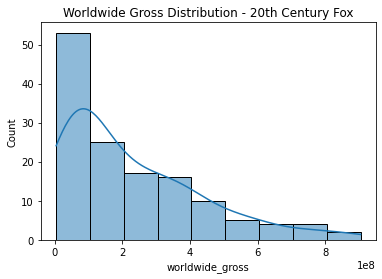

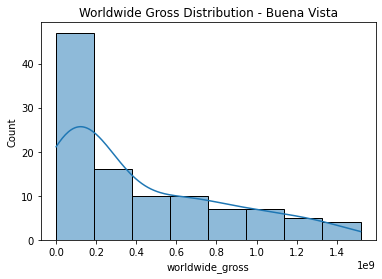

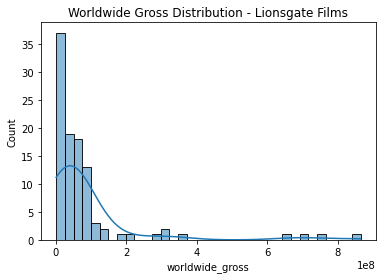

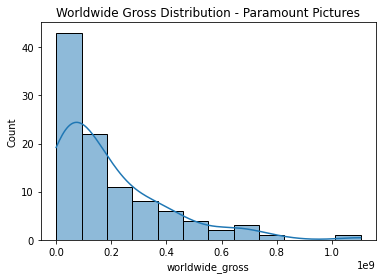

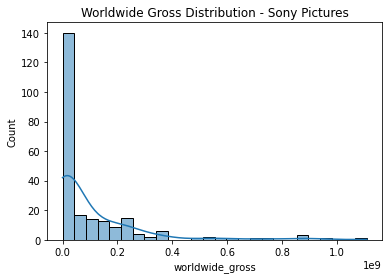

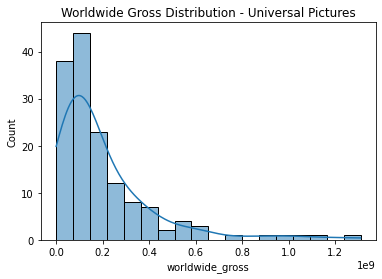

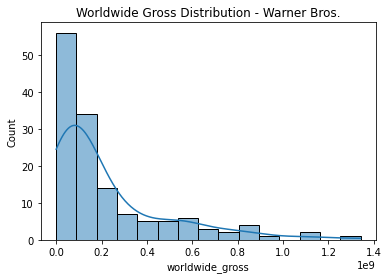

In [71]:
for studio, group in df_bom_top_studios.groupby('studio'):
    sns.histplot(group['worldwide_gross'], kde=True)
    plt.title(f"Worldwide Gross Distribution - {studio}")
    plt.show()

Since from the above we can clearly see the data isn't normally distributed, we can use the Kruskal-Wallis test as the alternative.

In [74]:
# Group data by studios
groups = [group['worldwide_gross'] for name, group in df_bom_top_studios.groupby('studio')]

# Perform Kruskal-Wallis Test
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis H test statistic: {stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject null hypothesis: Significant difference in worldwide gross among studios.")
else:
    print("Fail to reject null hypothesis: No significant difference in worldwide gross among studios.")


Kruskal-Wallis H test statistic: 181.2734, p-value: 0.0000
Reject null hypothesis: Significant difference in worldwide gross among studios.


In [75]:
h_stat = stat  # From Kruskal-Wallis
n_total = len(df_bom_top_studios)  # Total number of observations
epsilon_squared = (h_stat - len(groups) + 1) / (n_total - len(groups))

print(f"Epsilon Squared (Effect Size): {epsilon_squared:.4f}")
if epsilon_squared < 0.01:
    print("Effect size: Negligible")
elif epsilon_squared < 0.06:
    print("Effect size: Small")
elif epsilon_squared < 0.14:
    print("Effect size: Medium")
else:
    print("Effect size: Large")

Epsilon Squared (Effect Size): 0.1831
Effect size: Large


In [76]:
# Summary statistics for each studio
df_bom_top_studios.groupby('studio')['worldwide_gross'].describe()

,count,mean,std,min,25%,50%,75%,max
studio,,,,,,,,
20th Century Fox,136.0,2.279806e+08,2.059785e+08,3933000.0,68175000.0,158500000.0,3.494250e+08,9.036000e+08
Buena Vista,106.0,4.171027e+08,4.128511e+08,84900.0,72075000.0,215950000.0,6.785260e+08,1.518900e+09
Lionsgate Films,102.0,8.426061e+07,1.495518e+08,495000.0,16548000.0,46850000.0,7.530000e+07,8.650000e+08
Paramount Pictures,101.0,1.935570e+08,2.053237e+08,366000.0,41800000.0,129200000.0,2.601000e+08,1.104000e+09
Sony Pictures,232.0,1.026024e+08,1.813504e+08,2500.0,2472750.0,19750000.0,1.344500e+08,1.108600e+09
Universal Pictures,147.0,2.024297e+08,2.246596e+08,22000.0,70850000.0,125500000.0,2.630500e+08,1.309500e+09
Warner Bros.,140.0,2.202568e+08,2.632616e+08,139000.0,46975000.0,112150000.0,2.804500e+08,1.341500e+09


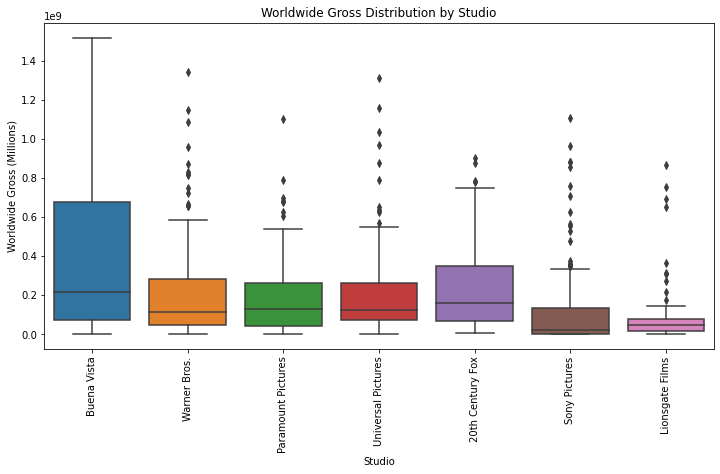

In [77]:
# Boxplot for worldwide_gross to check outliers visually
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_bom_top_studios, x='studio', y='worldwide_gross')
plt.title('Worldwide Gross Distribution by Studio')
plt.xlabel('Studio')
plt.ylabel('Worldwide Gross (Millions)')
plt.xticks(rotation=90)
plt.show()

In [78]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'worldwide_gross' for each studio
Q1 = df_bom_top_studios.groupby('studio')['worldwide_gross'].quantile(0.25)
Q3 = df_bom_top_studios.groupby('studio')['worldwide_gross'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Determine the lower and upper bounds for each studio's 'worldwide_gross'
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Map the lower and upper bounds to match each studio in the dataframe
df_bom_top_studios['lower_bound'] = df_bom_top_studios['studio'].map(lower_bound)
df_bom_top_studios['upper_bound'] = df_bom_top_studios['studio'].map(upper_bound)

# Create a mask to filter the rows that do not have outliers
mask = (df_bom_top_studios['worldwide_gross'] >= df_bom_top_studios['lower_bound']) & \
       (df_bom_top_studios['worldwide_gross'] <= df_bom_top_studios['upper_bound'])

# Apply the mask to remove the outliers
df_bom_top_studios_no_outliers = df_bom_top_studios[mask]

# Check the number of records before and after outlier removal
print(f"Before: {len(df_bom_top_studios)} records")
print(f"After: {len(df_bom_top_studios_no_outliers)} records")

# Optional: Summary statistics for the cleaned data
df_bom_top_studios_no_outliers.groupby('studio')['worldwide_gross'].describe()

Before: 964 records
After: 902 records


<ipython-input-78-bcc7edaf6123>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bom_top_studios['lower_bound'] = df_bom_top_studios['studio'].map(lower_bound)
<ipython-input-78-bcc7edaf6123>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bom_top_studios['upper_bound'] = df_bom_top_studios['studio'].map(upper_bound)


,count,mean,std,min,25%,50%,75%,max
studio,,,,,,,,
20th Century Fox,132.0,2.095641e+08,1.789104e+08,3933000.0,67425000.0,151950000.0,3.305500e+08,7.478000e+08
Buena Vista,106.0,4.171027e+08,4.128511e+08,84900.0,72075000.0,215950000.0,6.785260e+08,1.518900e+09
Lionsgate Films,92.0,4.325627e+07,3.436300e+07,495000.0,9884000.0,43650000.0,6.660000e+07,1.424000e+08
Paramount Pictures,94.0,1.528708e+08,1.389163e+08,366000.0,39900000.0,112350000.0,2.386750e+08,5.400000e+08
Sony Pictures,214.0,5.963204e+07,8.335577e+07,2500.0,2225000.0,12979500.0,1.017000e+08,3.313000e+08
Universal Pictures,137.0,1.542691e+08,1.250183e+08,22000.0,64100000.0,114200000.0,2.120000e+08,5.494000e+08
Warner Bros.,127.0,1.536531e+08,1.552307e+08,139000.0,42750000.0,104900000.0,2.129000e+08,5.868000e+08


In [79]:
#Saving as a CSV
df_bom.to_csv('BOMCleanData.csv', index = False)
df_tmdb.to_csv('TDMBCleanData.csv', index = False)
df_imdb.to_csv('IMDBCleanData.csv', index = False)
df_tn.to_csv('TNCleanData.csv', index = False)

# Exploratory Data Analysis

EDA allows you to understand the data better before building models. It involves visualizing the data and understanding relationships between variables. Effective visualizations provide insight into the data and help in decision-making regarding further data preprocessing and modeling.

## Calling the clean dataframes.

We need to have a picture of the data we are working with so we call the dataframes.

###  BOM Dataframe

In [80]:
# Call the first 5 rows of BOM dataframe
df_bom.head()

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross,studio_name
0,Toy Story 3,Buena Vista,415000000.0,652000000.0,2010,1.067000e+09,Buena Vista
1,Alice In Wonderland (2010),Buena Vista,334200000.0,691300000.0,2010,1.025500e+09,Buena Vista
2,Harry Potter And The Deathly Hallows Part 1,Warner Bros.,296000000.0,664300000.0,2010,9.603000e+08,Warner Bros.
3,Inception,Warner Bros.,292600000.0,535700000.0,2010,8.283000e+08,Warner Bros.
4,Shrek Forever After,Other,238700000.0,513900000.0,2010,7.526000e+08,Paramount/DreamWorks


In [81]:
# Call the columns of the dataframe 
df_bom.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'worldwide_gross', 'studio_name'],
      dtype='object')

In [82]:
# Call the datatypes of the above columns
Bom_info = df_bom.info()
Bom_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3356 non-null   object 
 1   studio           3356 non-null   object 
 2   domestic_gross   3356 non-null   float64
 3   foreign_gross    3356 non-null   float64
 4   year             3356 non-null   int64  
 5   worldwide_gross  3356 non-null   float64
 6   studio_name      3356 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 209.8+ KB


We can see the above dataframe has 7 columns which are :('title', 'studio', 'domestic_gross', 'foreign_gross', 'year','worldwide_gross', 'studio_name'). Their datatypes are : (object,  object, float64, float64, int64, float64, object) respectively

### IMDB Dataframe

In [83]:
# Call the first 5 rows of IMDB dataframe
df_imdb.head()

,movie_id,title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263


In [84]:
# Call the columns of the dataframe 
df_imdb.columns

Index(['movie_id', 'title', 'original_title', 'start_year', 'runtime_minutes',
       'genres', 'averagerating', 'numvotes'],
      dtype='object')

In [85]:
# Call the datatypes of the above columns
IMDB_info = df_imdb.info()
IMDB_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65720 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   title            65720 non-null  object 
 2   original_title   65720 non-null  object 
 3   start_year       65720 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           65720 non-null  object 
 6   averagerating    65720 non-null  float64
 7   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


We can see the above dataframe has 8 columns which are :('title', 'original_title', 'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes'). Their datatypes are : (object,  object, object, int64, float64, object, float64, int64) respectively.

### TMDB Dataframe

In [86]:
# Call the first 5 rows of TMDB dataframe
df_tmdb.head()

,id,popularity,release_date,title,vote_average,vote_count,genres
7,10193,24.445,2010-06-17,Toy Story 3,7.7,8340,"Animation, Family, Comedy"
8,20352,23.673,2010-07-09,Despicable Me,7.2,10057,"Animation, Family, Comedy"
9,38055,22.855,2010-11-04,Megamind,6.8,3635,"Animation, Action, Comedy, Family, Science Fic..."
10,863,22.698,1999-11-24,Toy Story 2,7.5,7553,"Animation, Comedy, Family"
11,12155,22.020,2010-03-05,Alice in Wonderland,6.6,8713,"Family, Fantasy, Adventure"


In [87]:
# Call the columns of the dataframe 
df_tmdb.columns

Index(['id', 'popularity', 'release_date', 'title', 'vote_average',
       'vote_count', 'genres'],
      dtype='object')

In [88]:
# Call the datatypes of the above columns
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3536 entries, 7 to 24546
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            3536 non-null   int64         
 1   popularity    3536 non-null   float64       
 2   release_date  3536 non-null   datetime64[ns]
 3   title         3536 non-null   object        
 4   vote_average  3536 non-null   float64       
 5   vote_count    3536 non-null   int64         
 6   genres        3536 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 221.0+ KB


We can see the above dataframe has columns which are : ('id', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count', 'genres'). Their datatypes are : (int64,  float64, datetime6, object, float64, int64, object) respectively.

### TN Dataframe

In [89]:
# Call the first 5 rows of TN dataframe
df_tn.head()

,release_date,title,production_budget,domestic_gross,worldwide_gross,profit
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09
1,2011-05-20,Pirates Of The Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08
3,2015-05-01,Avengers: Age Of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09
4,2017-12-15,Star Wars Ep. Viii: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08


In [90]:
# Call the columns of the dataframe 
df_tn.columns

Index(['release_date', 'title', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'profit'],
      dtype='object')

In [91]:
# Call the datatypes of the above columns
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   title              5782 non-null   object        
 2   production_budget  5782 non-null   float64       
 3   domestic_gross     5782 non-null   float64       
 4   worldwide_gross    5782 non-null   float64       
 5   profit             5782 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 271.2+ KB


We can see the above dataframe has 6 columns which are :('release_date', 'title', 'production_budget', 'domestic_gross', 'worldwide_gross', 'profit'). Their datatypes are : (datetime64,  object,  float64 ,  float64 , float64, float64) respectively.

We now have an overview of the data so we can move to the next step

## Analysis

### Univariate Analysis

Univariate Analysis is the simplest form of data analysis, where we examine a single variable (or feature) in isolation. 

**In this section, we will:**

1. Understand the distribution of the variable (e.g., whether it follows a normal distribution or has skewness).
2. Analyze the central tendency using metrics like mean, median, and mode.
3. Investigate the spread or variability using measures like standard deviation and range.
4. Visualize the data using simple tools like bar charts to gain insights into the characteristics of the data.

**Univariate analysis is essential because it allows us to:**

1. Summarize and simplify the data.
2. Identify patterns and trends that can inform further analysis.
3. Detect potential issues in the data, such as outliers or incorrect entries, that might need to be addressed.




#### Distribution of the Numeric variables

##### Profit variable

Here we try  to assess the distribution of the profit variable that is, whether it follows a normal distribution or has skewness.

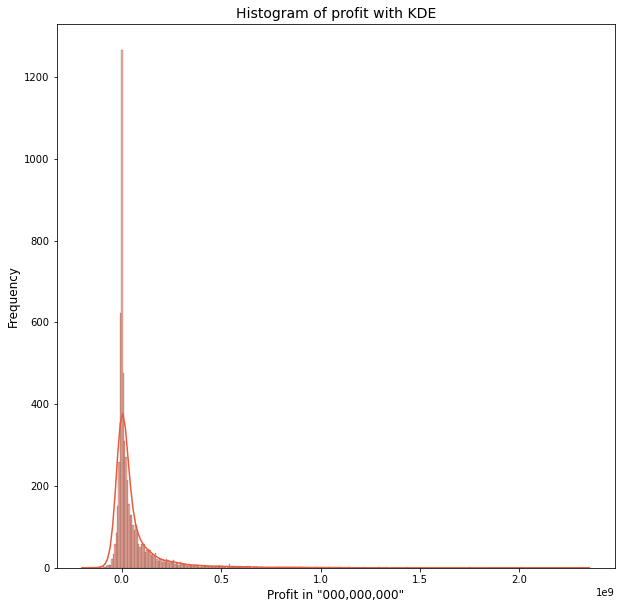

Skewness: 4.842793710737789


<Figure size 432x288 with 0 Axes>

In [92]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,10)) # Specify the size of the plot

# Plot the histogram on the axis 'ax'
sns.histplot(df_tn['profit'], kde=True, color='#EB5A3C', ax=ax)

# Add title and labels
ax.set_title('Histogram of profit with KDE', fontsize=14)
ax.set_xlabel('Profit in "000,000,000"', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

# Calculate skewness
from scipy.stats import skew
print(f"Skewness: {skew(df_tn['profit'])}")
plt.savefig('Profit_Distribution.png') #Saves an image of the figure

###### **Insight**

From the above histogram we can see the data is not normally distributed. It shows skewness to the right thus in our analysis we will have to use non parametric tests or use log transformation where profit is concerned. The skewness value  (4.842793710737789) is  positive, confirming the right skew.

##### Average rating variable 

Here we try  to assess the distribution of the average rating variable that is, whether it follows a normal distribution or has skewness.

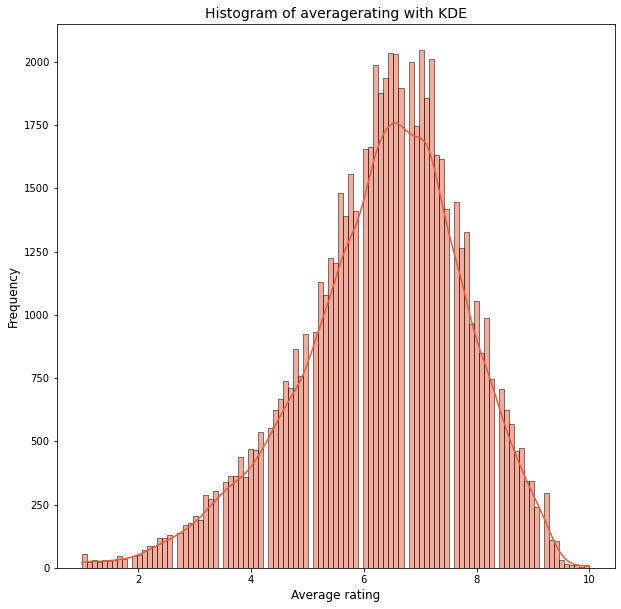

Skewness: -0.5475539593623235


<Figure size 432x288 with 0 Axes>

In [93]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,10)) # Specify the size of the plot

# Plot the histogram on the axis 'ax'
sns.histplot(df_imdb['averagerating'], kde=True, color='#EB5A3C', ax=ax)

# Add title and labels
ax.set_title('Histogram of averagerating with KDE', fontsize=14)
ax.set_xlabel('Average rating', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

# Calculate skewness
from scipy.stats import skew
print(f"Skewness: {skew(df_imdb['averagerating'])}")

plt.savefig('averagerating_Distribution.png') #Saves an image of the figure

###### **Insight**

The above histogram shows the Average rating data is not normally distributed. It shows skewness to the left thus in our analysis we will have to use non parametric tests or use log transformation where Average rating is concerned . The skewness value  ( -0.5475539593623235) is  negative, confirming the left skew.

#### Visualisations

In this section we visualize the data using simple tools like bar charts to gain insights into the characteristics of the data.

##### Most popular studios

We come up with a bar plot to show the most popular studios when it comes to movie production.

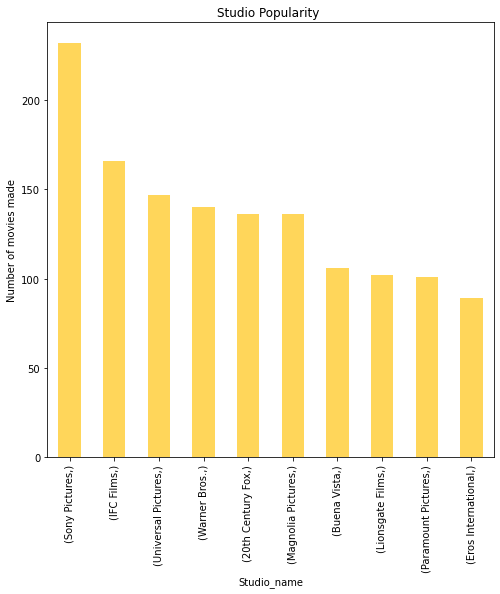

In [94]:
# filter the top 10 studios producing most movies
studio_popularity= df_bom[['studio_name']].value_counts().iloc[1:].head(10)

# Plot the result
fig, ax = plt.subplots(figsize = (8,8)) #initialise the figure and set the size to (8,8)


studio_popularity.plot(kind = 'bar', color = '#FFD65A'); #creates a bar plot and sets the barplot color to orange
ax.set_title('Studio Popularity ')#Labels the plot
ax.set_xlabel('Studio_name') #labels the x axis
ax.set_ylabel('Number of movies made') #Labels the y axis

plt.savefig('Studio_Popularity.png') #Saves an image of the figure

In [95]:
#Returns the top 10 studios
studio_popularity

studio_name       
Sony Pictures         232
IFC Films             166
Universal Pictures    147
Warner Bros.          140
20th Century Fox      136
Magnolia Pictures     136
Buena Vista           106
Lionsgate Films       102
Paramount Pictures    101
Eros International     89
dtype: int64

###### **Insight**

The top 10 studios are:
1. Sony Pictures with 232 movies 
2. IFC Films with 166 movies
3. Universal Pictures with 147 movies
4. Warner Bros with 140 movies
5. 20th Century Fox with 136 movies
6. Magnolia Pictures with 136 movies
7. Buena Vista with 106 movies
8. Lionsgate Films with 102 movies
9. Paramount Pictures with 101 movies
10. Eros International with 89 movies

This shows us they are the most preferred studios for movie production.

##### Most popular director 

We plot a bar plot to show the most popular Directors alive when it comes to movie production.

In [96]:
# We merge the data from IMDb where we filtered the crew who are still alive with the TN data on the 'title' column where only the movies that are on both  dataframes are kept.
MergedDF = pd.merge(alive_directors_movies, df_tn , on='title', how='inner')
#We split the different professions within the primary profession column from the grouped profession to single professions
director_df_1 = MergedDF.assign(primary_profession=MergedDF['primary_profession'].str.split(',')).explode('primary_profession')

#Filter out the records with more than 100 votes 
director_df_2 = director_df_1[director_df_1['numvotes'] >= 100]

#Filter out other records remaining with the directors only.
director_df = director_df_2[director_df_2['primary_profession'] == 'director']


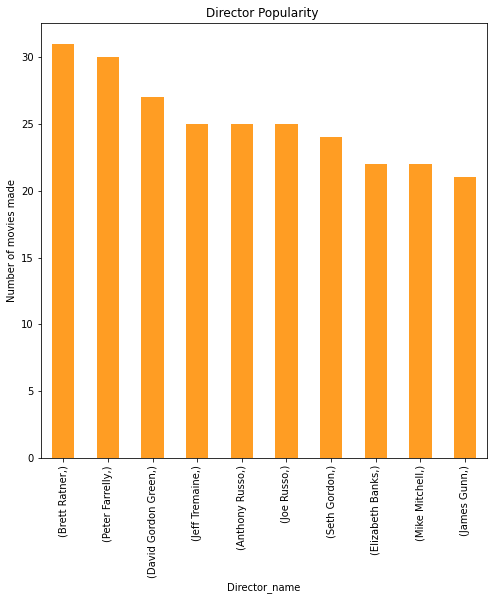

In [97]:
#Number of occurrences per studio
Director_popularity= director_df[['primary_name']].value_counts().head(10)

# create a figure and one plot
fig, ax = plt.subplots(figsize = (8,8)) #initialise the figure and set the size to (8,8)


Director_popularity.plot(kind = 'bar', color = '#FF9D23'); #creates a bar plot and sets the barplot color to orange
ax.set_title('Director Popularity ')#Labels the plot
ax.set_xlabel('Director_name') #labels the x axis
ax.set_ylabel('Number of movies made') #Labels the y axis

plt.savefig('Director_Popularity.png') #Saves an image of the figure

In [98]:
# List the top 10 directors alive
Director_popularity

primary_name      
Brett Ratner          31
Peter Farrelly        30
David Gordon Green    27
Jeff Tremaine         25
Anthony Russo         25
Joe Russo             25
Seth Gordon           24
Elizabeth Banks       22
Mike Mitchell         22
James Gunn            21
dtype: int64

###### **Insights**

From this we see that the top 10 directors are:
1. Brett Ratner with 31 movies
2. Peter Farrelly with 30 movies
3. David Gordon Green with 27 movies
4. Jeff Tremaine with 25 movies 
5. Anthony Russo with 25 movies
6. Joe Russo with 25 movies
7. Seth Gordon with 24 movies
8. Elizabeth Banks with 22 movies
9. Mike Mitchell with 22 movies
10. James Gunn with 21 movies

These are the most preferred directors for movie production.

##### Most produced genres

We plot a bar plot to visualised the most popular genres when it comes to movie production.

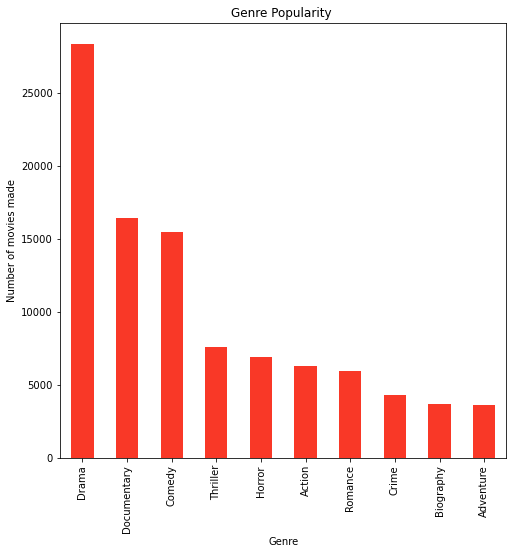

In [99]:
#Number of occurrences per genre(top 10)
Genre_production_Popularity= df_imdb["genres"].str.split(',').explode().value_counts().head(10)

# create a figure and one plot
fig, ax = plt.subplots(figsize = (8,8)) #initialise the figure and set the size to (8,8)


Genre_production_Popularity.plot(kind = 'bar', color = '#F93827'); #creates a bar plot and sets the barplot color to orange
ax.set_title('Genre Popularity ')#Labels the plot
ax.set_xlabel('Genre') #labels the x axis
ax.set_ylabel('Number of movies made') #Labels the y axis

plt.savefig('Genre_Popularity.png') #Saves an image of the figure

In [100]:
# Return the top 10 genres
Genre_production_Popularity

Drama          28394
Documentary    16423
Comedy         15514
Thriller        7583
Horror          6917
Action          6297
Romance         5976
Crime           4338
Biography       3693
Adventure       3621
Name: genres, dtype: int64

###### Insights

From this we can conclude the top 10 genres are:
1. Drama with 28394 movies
2. Documentary with 16423 movies
3. Comedy with 15514 movies
4. Thriller with 7583 movies 
5. Horror with 6917 movies
6. Action with 6297 movies
7. Romance with 5976 movies
8. Crime with 4338 movies
9. Biography with 3693 movies
10. Adventure with 3621 movies

These are the most preferred movies genres.

#### Measures of central tendency and dispersion.

We use measures like mean, mode, median, standard deviation and variance.

##### Profit variable

Being a numerical variable we expect the mean median and standard deviation.

In [101]:
# Call the profit variable and perform a descriptive statistics.
profit_variable_measures = df_tn['profit'].describe()
median_profit = df_tn['profit'].median()
print(profit_variable_measures)
print(f"median = {median_profit}")

count    5.782000e+03
mean     5.989970e+07
std      1.460889e+08
min     -2.002376e+08
25%     -2.189071e+06
50%      8.550286e+06
75%      6.096850e+07
max      2.351345e+09
Name: profit, dtype: float64
median = 8550285.5


From the data we see a mean profit of 50000000 with a standard deviation of 146088900. This shows us:
1. A large standard deviation suggests that the profits vary widely from the mean, indicating high volatility or inconsistency in the data. Some profits may be much lower or much higher than the mean.
2. The median gives us a better idea of the central tendency of the majority of the profits, showing that the typical profit is much lower than the mean.
3. The standard deviation reinforces the idea that there is considerable variability in the data, which could be driven by a small number of high-profit values.


##### Average rating

Being a numerical variable we expect the mean median and standard deviation.

In [102]:
averagerating_variable_measures = df_imdb['averagerating'].describe()
median_averagerating = df_imdb['averagerating'].median()
print(averagerating_variable_measures)
print( f"median = {median_averagerating}")

count    65720.000000
mean         6.320902
std          1.458878
min          1.000000
25%          5.500000
50%          6.500000
75%          7.300000
max         10.000000
Name: averagerating, dtype: float64
median = 6.5


From the data we see a mean rating of 6.32 with a standard deviation of 1.46 and a median of 6.5. This shows us:
1. This range suggests that while there is variability in the ratings, most of the ratings fall within a reasonable spread around the mean.
2. Although the mean and median are close, there might still be slight skewness if the distribution is not perfectly symmetric. The mean being slightly lower than the median might indicate that there are a few lower ratings that are pulling the mean down (negative skew)
3. The median rating (6.5) represents the "typical" rating in the dataset, as it is the middle value. This suggests that the "typical" rating falls just above the 6 mark, closer to the higher end of the rating scale, indicating that most users seem to rate the items slightly higher than 6.

### Bivariate Analysis

Bivariate Analysis involves the examination of two variables to understand the relationship between them. This type of analysis helps to identify patterns, correlations, and dependencies between variables.

In this section, we will:

Explore the relationship between two variables (e.g., how one variable impacts another or if they move together).
Examine the correlation coefficient (such as Pearson's or Spearman's correlation) to assess the strength and direction of the relationship.
Use scatter plots, cross-tabulations, or other visualizations to gain insights into how the variables interact.
Perform hypothesis tests (e.g., t-tests, chi-square tests) to confirm whether the relationship is statistically significant.
Bivariate analysis is essential because it allows us to:

Understand if and how two variables are related to each other.
Identify causal relationships or correlations that might inform predictive models.
Detect any significant differences or patterns between the two variables.
Simplify the complexity of multi-variable relationships by focusing on the interaction between two variables

#### Genre success based on profit accrued

1. Summary Statistics: Compute summary statistics (mean, median, standard deviation) for profits within each genre.
2. Visualizations: Create visualizations to compare the profit across different genres.
3. Statistical Tests: Apply tests like ANOVA or Kruskal-Wallis H Test to statistically test if the differences in profit across genres are significant.

##### Single genre

In [103]:
#Takes the 'genres' column, splits the comma separated values into lists, and then "explodes" each list into separate rows for further analysis.
genres_explode = MergedDF.assign(genres=MergedDF['genres'].str.split(',')).explode('genres')


# Calculate summary statistics (mean, median, variance) by genre
summary_stats_single_genre = genres_explode.groupby('genres')['profit'].describe()
summary_stats_single_genre

,count,mean,std,min,25%,50%,75%,max
genres,,,,,,,,
Action,1567.0,2.013837e+08,3.180932e+08,-200237650.0,4863840.00,71487563.0,2.793279e+08,1.748134e+09
Adventure,1393.0,2.950174e+08,3.545513e+08,-200237650.0,28031715.00,178731369.0,4.620800e+08,1.748134e+09
Animation,644.0,2.849406e+08,2.892907e+08,-110450242.0,44293168.00,208541369.0,4.744646e+08,1.122470e+09
Biography,314.0,6.511888e+07,1.194204e+08,-48884073.0,-2479451.00,22651864.0,9.563672e+07,8.399853e+08
Comedy,2000.0,1.211601e+08,2.053033e+08,-63357202.0,4142072.00,24052249.0,1.375786e+08,1.122470e+09
Crime,649.0,4.210334e+07,1.025984e+08,-90000000.0,-3879984.00,8495213.0,5.527529e+07,1.328723e+09
Documentary,365.0,3.331043e+07,8.447227e+07,-59500000.0,-2727133.00,-100000.0,3.729337e+07,6.792360e+08
Drama,2625.0,4.159422e+07,9.993377e+07,-79448583.0,-4000000.00,4856688.0,4.429317e+07,1.122470e+09
Family,394.0,1.050580e+08,1.715397e+08,-110450242.0,18986335.75,44168692.0,8.115912e+07,7.878545e+08


###### Visual

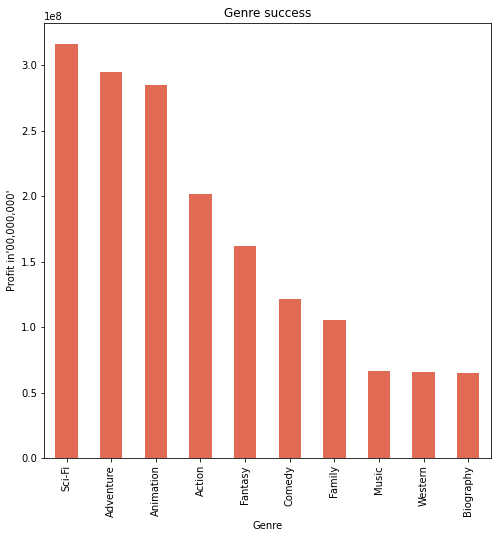

In [104]:
# Prepare the data for ploting
genres_totals=  genres_explode.groupby('genres')['profit'].mean()#calculate the mean profit per genre
top_10_genres_df = genres_totals.nlargest(10) #Filter the top 10 profit earning genres

# create a figure and one plot
fig, ax = plt.subplots(figsize = (8,8)) #initialise the figure and set the size to (8,8)


top_10_genres_df.plot(kind = 'bar', color = '#E16A54'); #creates a bar plot and sets the barplot color to orange
ax.set_title('Genre success')#Labels the plot
ax.set_xlabel('Genre') #labels the x axis
ax.set_ylabel("Profit in'00,000,000'") #Labels the y axis

plt.savefig('Genre_Success.png') #Saves an image of the figure

In [105]:
#Return the top 10 profit earning genres
top_10_genres_df 

genres
Sci-Fi       3.162636e+08
Adventure    2.950174e+08
Animation    2.849406e+08
Action       2.013837e+08
Fantasy      1.617725e+08
Comedy       1.211601e+08
Family       1.050580e+08
Music        6.652144e+07
Western      6.596435e+07
Biography    6.511888e+07
Name: profit, dtype: float64

From this we can conclude that the top 10  genres on average profit earned are:
1. Sci-Fi with $316,263,600 profit on average
2. Adventure with $295,017,400 profit on average
3. Animation with $284,940,600 profit on average
4. Action with $201,383,700 profit on average
5. Fantasy with $161,772,500 profit on average
6. Comedy with $121,160,100 profit on average
7. Family with $105,058,080 profit on average
8. Music with $66,521,440 profit on average
9. Western with $65,964,350 profit on average
10. Biography with $65,118,880 profit on average

In [106]:
individual_genres =genres_explode['genres'].unique()
individual_genres

array(['Action', 'Drama', 'Thriller', 'Biography', 'Comedy', 'Crime',
       'Romance', 'Documentary', 'Sci-Fi', 'Fantasy', 'Horror', 'War',
       'History', 'Adventure', 'Animation', 'Mystery', 'Family', 'Sport',
       'Western', 'Musical', 'Music', 'News'], dtype=object)

Perform Kruskal-Wallis H Test to test relationship between profits and genres

1. Null Hypothesis (H₀): There is no significant difference in profits between the genres.
2. Alternative Hypothesis (H₁): There is a significant difference in profits between the genres.

In [107]:

# Group data by genres
groups_genres = [genres_explode[genres_explode['genres'] == genres]['profit'] for genres in individual_genres]

# Perform Kruskal-Wallis H Test
h_stat_genres, p_value_genres = stats.kruskal(*groups_genres)

print(f'H-statistic = {h_stat_genres}, p-value = {p_value_genres}')

# Interpretation
if p_value_genres < 0.05:
    print("Reject the null hypothesis: There is a significant difference in profit between genres.")
else:
    print("Fail to reject the null hypothesis: No significant difference in profit between genres.")

H-statistic = 1940.864029117383, p-value = 0.0
Reject the null hypothesis: There is a significant difference in profit between genres.


1. This indicates that the observed differences in profits across genres are statistically significant therefore genres have an influence on profit
2. H-statistic: 1940.864, indicating substantial differences in the ranks of profits across genres.



Genre Combination

In [108]:
# Calculate summary statistics (mean, median, variance) by genre combinations
summary_stats_combined_genre = MergedDF.groupby('genres')['profit'].describe()
summary_stats_combined_genre

,count,mean,std,min,25%,50%,75%,max
genres,,,,,,,,
Action,18.0,7.589358e+07,9.749744e+07,-39536270.0,1100000.00,64544947.0,7.513557e+07,2.674165e+08
"Action,Adventure",1.0,-4.488226e+06,NaN,-4488226.0,-4488226.00,-4488226.0,-4.488226e+06,-4.488226e+06
"Action,Adventure,Animation",85.0,2.826411e+08,2.040842e+08,52737201.0,52737201.00,377599142.0,4.380684e+08,1.042521e+09
"Action,Adventure,Biography",12.0,1.381721e+08,1.646307e+08,18585047.0,22897191.00,22897191.0,2.167074e+08,3.979383e+08
"Action,Adventure,Comedy",78.0,2.800369e+08,2.492076e+08,-63357202.0,59240813.00,277899733.0,3.888584e+08,7.430256e+08
...,...,...,...,...,...,...,...,...
Romance,8.0,-7.708253e+06,1.842191e+07,-53296816.0,-1286535.00,-1286535.0,-1.286535e+06,-6.500000e+05
"Romance,Sci-Fi,Thriller",2.0,7.673132e+07,0.000000e+00,76731325.0,76731325.00,76731325.0,7.673132e+07,7.673132e+07
Sci-Fi,12.0,3.558434e+08,3.300501e+08,-1500000.0,56767487.75,370453347.5,6.711334e+08,6.711334e+08


###### Visual

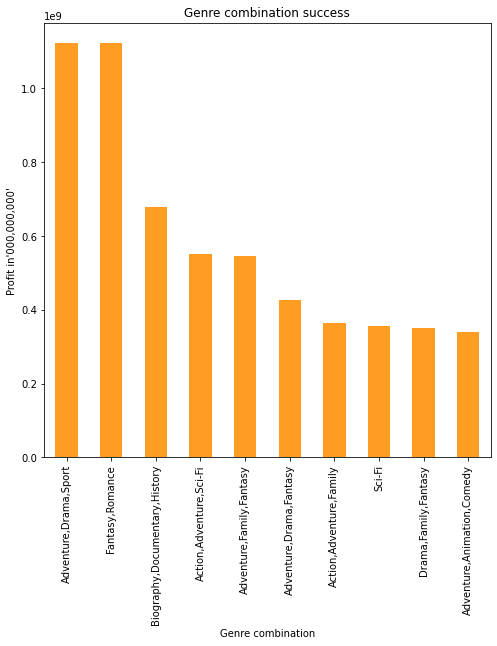

In [111]:
#Prepare data for plotting
genres_mean_2=  MergedDF.groupby('genres')['profit'].mean()
top_10_genres_df2 = genres_mean_2.nlargest(10)
fig, ax = plt.subplots(figsize = (8,8)) #initialise the figure and set the size to (8,8)


top_10_genres_df2.plot(kind = 'bar', color = '#FF9D23'); #creates a bar plot and sets the barplot color to Orange
ax.set_title('Genre combination success')#Labels the plot
ax.set_xlabel('Genre combination') #labels the x axis
ax.set_ylabel("Profit in'000,000,000'") #Labels the y axis

plt.savefig('Genre_Success2.png') #Saves an image of the figure

In [112]:
#Return top 10 genre combinations average profit 
top_10_genres_df2

genres
Adventure,Drama,Sport            1.122470e+09
Fantasy,Romance                  1.122470e+09
Biography,Documentary,History    6.792360e+08
Action,Adventure,Sci-Fi          5.514776e+08
Adventure,Family,Fantasy         5.450039e+08
Adventure,Drama,Fantasy          4.253186e+08
Action,Adventure,Family          3.633559e+08
Sci-Fi                           3.558434e+08
Drama,Family,Fantasy             3.501214e+08
Adventure,Animation,Comedy       3.403324e+08
Name: profit, dtype: float64

From this we can conclude that the top 10  genres on average profit earned are:
1. Adventure,Drama,Sport with $1,122,470,000 profit on average
1. Fantasy,Romance with $1,122,470,000 profit on average
3. Biography,Documentary,History with $679,236,000 profit on average
4. Action,Adventure,Sci-Fi  with $551,477,600 profit on average
5. Adventure,Family,Fantasy with $545,003,900 profit on average
6. Adventure,Drama,Fantasy with $425,318,600 profit on average
7. Action,Adventure,Family with $363,355,900 profit on average
8. Sci-Fi with $355,843,400 profit on average
9. Drama,Family,Fantasy  with $350,121,400 profit on average
10. Adventure,Animation,Comedy with $340,332,400 profit on average

 #### Director success based on profit accrued

1. Summary Statistics: Compute summary statistics (mean, median, standard deviation) for profits by each director.
2. Visualizations: Create visualizations to compare the profit by different directors.
3. Statistical Tests: Apply tests like ANOVA or Kruskal-Wallis H Test to statistically test if the differences in profit made by directors are significant.

In [113]:
# Calculate summary statistics (mean, median, variance) by director
summary_stats_director = director_df.groupby('primary_name')['profit'].describe()
summary_stats_director

,count,mean,std,min,25%,50%,75%,max
primary_name,,,,,,,,
Aaron Hann,2.0,-1989976.0,0.000000e+00,-1989976.0,-1989976.0,-1989976.0,-1989976.0,-1989976.0
Aaron Seltzer,2.0,61424988.0,0.000000e+00,61424988.0,61424988.0,61424988.0,61424988.0,61424988.0
Aaron T. Wells,3.0,-500000.0,0.000000e+00,-500000.0,-500000.0,-500000.0,-500000.0,-500000.0
Aashiq Abu,3.0,-44373310.0,0.000000e+00,-44373310.0,-44373310.0,-44373310.0,-44373310.0,-44373310.0
Abby Kohn,2.0,59553797.0,0.000000e+00,59553797.0,59553797.0,59553797.0,59553797.0,59553797.0
...,...,...,...,...,...,...,...,...
Zack Snyder,12.0,299080739.0,1.328068e+08,14758389.0,355945209.0,355945209.0,355945209.0,355945209.0
Zal Batmanglij,2.0,-3472044.0,0.000000e+00,-3472044.0,-3472044.0,-3472044.0,-3472044.0,-3472044.0
Zhengyu Lu,7.0,23689126.0,0.000000e+00,23689126.0,23689126.0,23689126.0,23689126.0,23689126.0


##### Visual

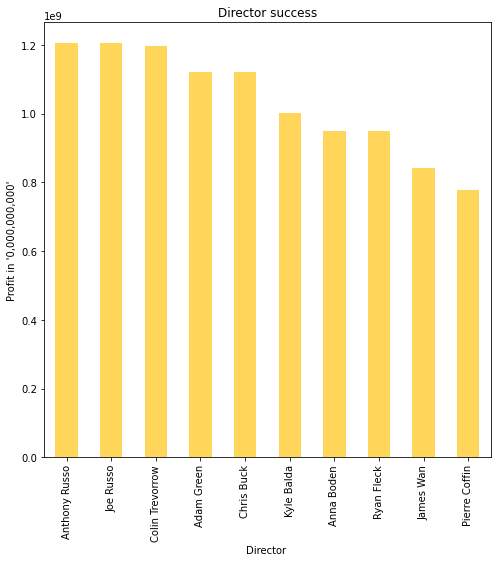

In [114]:
Director_totals=  director_df.groupby('primary_name')['profit'].mean() #average profit per director
top_10_directors_df = Director_totals.nlargest(10)#average profit per top 10 director
fig, ax = plt.subplots(figsize = (8,8)) #initialise the figure and set the size to (8,8)


top_10_directors_df.plot(kind = 'bar', color = '#FFD65A'); #creates a bar plot and sets the barplot color to Orange
ax.set_title('Director success')#Labels the plot
ax.set_xlabel('Director ') #labels the x axis
ax.set_ylabel("Profit in '0,000,000,000'") #Labels the y axis

plt.savefig('director_Success.png') #Saves an image of the figure

In [115]:
#Call average profit per top 10 director
top_10_directors_df


primary_name
Anthony Russo      1.205154e+09
Joe Russo          1.205154e+09
Colin Trevorrow    1.195491e+09
Adam Green         1.122470e+09
Chris Buck         1.122470e+09
Kyle Balda         1.001931e+09
Anna Boden         9.480616e+08
Ryan Fleck         9.480616e+08
James Wan          8.430168e+08
Pierre Coffin      7.784524e+08
Name: profit, dtype: float64

From this we can conclude that the top 10  directors by average profit earned are:
1. Anthony Russo with $1,205,154,000 average profit
2. Joe Russo with $1,205,154,000 average profit
3. Colin Trevorrow with $1,195,491,000 average profit
4. Adam Green with $1,122,470,000 average profit
5. Chris Buck with $1,122,470,000 average profit
6. Kyle Balda with $1,001,931,000 average profit
7. Anna Boden with $948,061,600 average profit
8. Ryan Fleck with $948,061,600 average profit
9. James Wan with $843,016,808 average profit
10. Pierre Coffin  with $778,452,400 average profit

Perform Kruskal-Wallis H Test to test relationship between profits and directors
1. Null Hypothesis (H₀): There is no significant difference in profits between directors.
2. Alternative Hypothesis (H₁): There is a significant difference in profits between directors.

In [116]:
# List of directors' names
director_names = director_df['primary_name'].unique()
director_names
# Group data by directors
groups_directors = [director_df[director_df['primary_name'] ==primary_name]['profit'] for primary_name in director_names]

# Perform Kruskal-Wallis H Test
h_stat_directors, p_value_directors = stats.kruskal(*groups_directors)

print(f'H-statistic = {h_stat_directors}, p-value = {p_value_directors}')

# Interpretation
if p_value_directors < 0.05:
    print("Reject the null hypothesis: There is a significant difference in profit between directors.")
else:
    print("Fail to reject the null hypothesis: No significant difference in profit between directors.")


H-statistic = 3915.855305140987, p-value = 2.3894293007187275e-259
Reject the null hypothesis: There is a significant difference in profit between directors.


1. H-statistic: 3915.855, indicating substantial differences in the ranks of profits across directors.
2. P-value:2.39×10−259, which is essentially zero. This extremely small p-value confirms that the observed differences are highly unlikely to occur by random chance.
3. There is overwhelming evidence to conclude that profits significantly differ among directors.

#### Studios average worldwide gross as a measure of success

1. Summary Statistics: Compute summary statistics (mean, median, standard deviation) for worldwide gross by each studio.
2. Visualizations: Create visualizations to compare the worldwide gross by different studios.
3. Statistical Tests: Apply tests like ANOVA or  to statistically test if the differences in worldwide gross made by studios are significant.

In [117]:
# Calculate summary statistics (mean, median, variance) by studio
summary_stats_studio = df_bom.groupby('studio_name')['worldwide_gross'].describe()
summary_stats_studio

,count,mean,std,min,25%,50%,75%,max
studio_name,,,,,,,,
20th Century Fox,136.0,2.279806e+08,2.059785e+08,3933000.0,68175000.0,158500000.0,349425000.0,9.036000e+08
3D Entertainment,1.0,1.600000e+07,NaN,16000000.0,16000000.0,16000000.0,16000000.0,1.600000e+07
ATO Pictures,4.0,5.820500e+05,4.191006e+05,114000.0,303000.0,586750.0,865800.0,1.040700e+06
Abramorama,10.0,1.642330e+06,3.784054e+06,11400.0,182000.0,221000.0,965500.0,1.230000e+07
Anchor Bay Entertainment,18.0,1.876583e+06,3.377150e+06,800.0,41750.0,209500.0,1746125.0,1.231200e+07
...,...,...,...,...,...,...,...,...
Warner Bros.,140.0,2.202568e+08,2.632616e+08,139000.0,46975000.0,112150000.0,280450000.0,1.341500e+09
Warner Bros. (New Line Cinema),45.0,2.296600e+08,2.447866e+08,20600000.0,78900000.0,148900000.0,288300000.0,1.021100e+09
World of Wonder,1.0,4.940000e+04,NaN,49400.0,49400.0,49400.0,49400.0,4.940000e+04


##### Visual

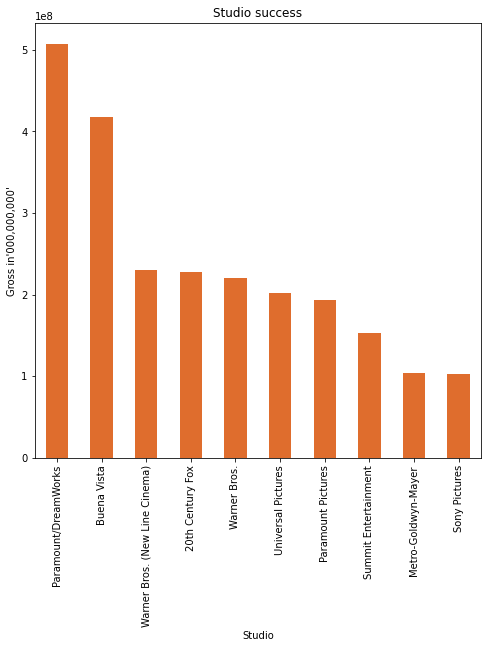

In [118]:
studio_totals=  df_bom.groupby('studio_name')['worldwide_gross'].mean()#average worldwide gross per studio
top_10_studios_df = studio_totals.nlargest(10)#average profit per top 10 director
fig, ax = plt.subplots(figsize = (8,8)) #initialise the figure and set the size to (8,8)


top_10_studios_df.plot(kind = 'bar', color = '#DF6D2D'); #creates a bar plot and sets the barplot color to Orange
ax.set_title('Studio success')#Labels the plot
ax.set_xlabel('Studio') #labels the x axis
ax.set_ylabel("Gross in'000,000,000'") #Labels the y axis

plt.savefig('Studio_Success.png') #Saves an image of the figure


In [119]:
top_10_studios_df

studio_name
Paramount/DreamWorks              5.076500e+08
Buena Vista                       4.171027e+08
Warner Bros. (New Line Cinema)    2.296600e+08
20th Century Fox                  2.279806e+08
Warner Bros.                      2.202568e+08
Universal Pictures                2.024297e+08
Paramount Pictures                1.935570e+08
Summit Entertainment              1.524514e+08
Metro-Goldwyn-Mayer               1.042000e+08
Sony Pictures                     1.026024e+08
Name: worldwide_gross, dtype: float64

From this we can conclude that the top 10  studios by average worldwide gross earned are:
1. Paramount/DreamWorks  with $507,650,000 worldwide gross
2. Buena Vista  with $417,102,700 worldwide gross
3. Warner Bros. (New Line Cinema) with $229,660,000 worldwide gross
4. 20th Century Fox  with $227,980,600 worldwide gross
5. Warner Bros with $220,256,800 worldwide gross
6. Universal Pictures with $202,429,700 worldwide gross
7. Paramount Pictures with $193,557,000 worldwide gross
8. Summit Entertainment with $152,451,400 worldwide gross
9. Metro-Goldwyn-Mayer with $104,200,000 worldwide gross
10. Sony Pictures  with $102,602,400 worldwide gross

Perform Kruskal-Wallis H Test to test relationship between profits and directors
1. Null Hypothesis (H₀): There is no significant difference in worldwide gross between studios.
2. Alternative Hypothesis (H₁): There is a significant difference in worldwide gross between studios.

In [120]:
# List of studio names
studio_names = df_bom['studio_name'].unique()

# Group data by studios
groups_studios = [df_bom[df_bom['studio_name'] ==studio_name]['worldwide_gross'] for studio_name in studio_names]

# Perform Kruskal-Wallis H Test
h_stat_studio, p_value_studio = stats.kruskal(*groups_studios)

print(f'H-statistic = {h_stat_studio}, p-value = {p_value_studio}')

# Interpretation
if p_value_studio < 0.05:
    print("Reject the null hypothesis: There is a significant difference in worldwide gross between studios.")
else:
    print("Fail to reject the null hypothesis: No significant difference in worldwide gross between studios.")

H-statistic = 1766.3486011632574, p-value = 0.0
Reject the null hypothesis: There is a significant difference in worldwide gross between studios.


1. H-statistic: 1766.349, indicating a strong effect of studio on worldwide gross.
2. P-value: 0.0 (or p<0.001), showing the observed differences are highly significant and not due to chance.
3. Worldwide gross significantly differs among studios therefore the production studio has a significant impact on Worldwide gross 

#### Average rating and its effect on profit


1. Visualization:
Scatterplots to visualize the relationship between ratings and profit.
Trend lines (e.g., linear or polynomial regression) to highlight patterns.
Statistical Analysis:
2. Compute the correlation coefficient i.e Pearson’s  to quantify the strength and direction of the relationship.


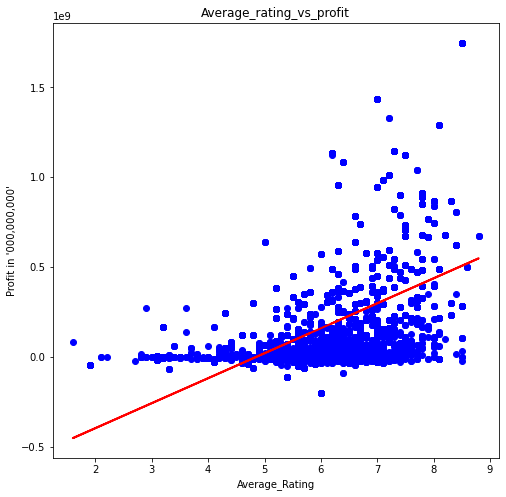

In [122]:
#Filter top 10 genres with more than 100 votes
genres_explode_1 =genres_explode[genres_explode['numvotes'] >= 100]
genres_explode_filtered = genres_explode_1[genres_explode_1['genres'].isin(top_10_genres_df.index)]

fig, ax = plt.subplots(figsize = (8,8)) #initialise the figure and set the size to (8,8)

ax.scatter(genres_explode_filtered['averagerating'], genres_explode_filtered['profit'], color='blue', label='Data points')


slope, intercept = np.polyfit(genres_explode_filtered['averagerating'], genres_explode_filtered['profit'], 1)  # 1 denotes linear fit

# Create a line using the slope and intercept
line = slope * genres_explode_filtered['averagerating'] + intercept

# Plot the line of best fit
ax.plot(genres_explode_filtered['averagerating'], line, color='red', linewidth=2, label='Line of Best Fit')
ax.set_title('Average_rating_vs_profit')#Labels the plot
ax.set_xlabel('Average_Rating') #labels the x axis
ax.set_ylabel("Profit in '000,000,000'") #Labels the y axis

plt.savefig('Average_rating_vs_profit') #Saves an image of the figure


From the above visual we can conclude there is a general increase in profit with an increase in average rating

Perform a Pearson correlation test
1. Null Hypothesis (H₀): There is no significant linear relationship.
2. Alternative Hypothesis (H₁): There is a significant linear relationship.



In [123]:
# Pearson correlation test
correlation, p_value_rating = stats.pearsonr(genres_explode_filtered['averagerating'], genres_explode_filtered['profit'])

print(f"Pearson Correlation: {correlation}")
print(f"P-Value: {p_value_rating}")

# Interpretation
if p_value_rating < 0.05:
    print("Reject the null hypothesis: There is a significant linear relationship.")
else:
    print("Fail to reject the null hypothesis: There is no significant linear relationship.")

Pearson Correlation: 0.51665645239573
P-Value: 0.0
Reject the null hypothesis: There is a significant linear relationship.


1. Pearson Correlation Coefficient: r=0.457
This indicates a moderate positive linear relationship between the two variables. As one variable increases, the other tends to increase as well, but the relationship is not perfectly linear.
2. P-Value: 0.0
The p-value is extremely small (close to 0), which is less than the commonly used significance level of 0.05. Therefore, we reject the null hypothesis.
3. There is sufficient evidence to conclude that there is a significant linear relationship between the two variables. This means that the relationship is statistically significant, and changes in one variable are associated with changes in the other variable.

### Multivariate analysis

The primary goals of multivariate analysis are to:
1. Identify relationships and interactions among multiple variables.
2. Classify data or identify natural groupings (e.g., cluster analysis).
3. Predict outcomes based on multiple predictors (e.g., multiple regression).

#### Genres relationship with average rating and profit

Goals:
1. Visualisation: Scatter plots can be used to visually show the relationship between average ratings and profit across genres.
2. Multivariate Analysis:Multiple Regression can be used to model the relationship between genre, average rating, and profit, allowing us to understand how these variables interact together to predict profit

In [124]:
# Calculate summary statistics (mean, median, variance) by genre
summary_stats_genre = genres_explode_filtered.groupby('genres')[['averagerating', 'profit']].describe()
summary_stats_genre

averagerating                                                  \
                  count      mean       std  min    25%  50%   75%  max   
genres                                                                    
Action           1485.0  6.349360  1.108766  1.9  5.700  6.4  7.00  8.8   
Adventure        1369.0  6.528050  1.068482  3.1  5.900  6.6  7.30  8.8   
Animation         606.0  6.605446  1.144640  1.9  6.000  6.7  7.40  8.4   
Biography         293.0  7.056997  0.714043  4.6  6.800  7.2  7.50  8.5   
Comedy           1897.0  5.985820  1.195140  1.9  5.100  6.2  6.80  8.5   
Family            241.0  6.403734  0.908631  3.8  5.800  6.5  7.10  8.0   
Fantasy           319.0  6.005643  0.914505  3.1  5.400  6.1  6.60  7.9   
Music             112.0  6.479464  1.046413  1.6  5.875  6.4  7.20  8.5   
Sci-Fi            519.0  6.463776  1.225500  2.8  5.800  6.6  7.20  8.8   
Western            27.0  6.744444  0.790975  4.8  6.400  6.6  7.25  8.4   

           profit                                                        \
            count          mean           std          min          25%   
genres                                                                    
Action     1485.0  2.105789e+08  3.239793e+08 -200237650.0   6433427.00   
Adventure  1369.0  2.993704e+08  3.558207e+08 -200237650.0  28527651.00   
Animation   606.0  2.917145e+08  2.859114e+08 -110450242.0  52737201.00   
Biography   293.0  6.506105e+07  1.168896e+08  -31979010.0  -2300000.00   
Comedy     1897.0  1.255503e+08  2.091780e+08  -63357202.0   5733666.00   
Family      241.0  1.478241e+08  2.063709e+08 -110450242.0   5898221.00   
Fantasy     319.0  1.577139e+08  2.227262e+08  -90000000.0   3946307.00   
Music       112.0  7.970339e+07  1.555169e+08  -25032507.0    -75140.75   
Sci-Fi      519.0  3.241579e+08  4.531316e+08 -200237650.0    356299.00   
Western      27.0  6.596435e+07  1.115178e+08  -60000000.0 -11390157.00   

                                                   
                   50%          75%           max  
genres                                             
Action      84827316.0  281333876.0  1.748134e+09  
Adventure  178847930.0  487127828.0  1.748134e+09  
Animation  219150134.0  474464573.0  1.122470e+09  
Biography   22651864.0   86963392.0  8.399853e+08  
Comedy      27427346.0  146739043.0  1.122470e+09  
Family      58291478.0  211528518.0  7.878545e+08  
Fantasy     49911903.0  262951941.0  9.868946e+08  
Music       14660323.0   72678948.0  8.399853e+08  
Sci-Fi     141521247.0  495183081.0  1.748134e+09  
Western     -2240304.0  144901042.0  3.499483e+08

#### Plotting a Scatter Plot and a line of best fit.

This will enable us to see relationship between the profit and average rating of the different genres.

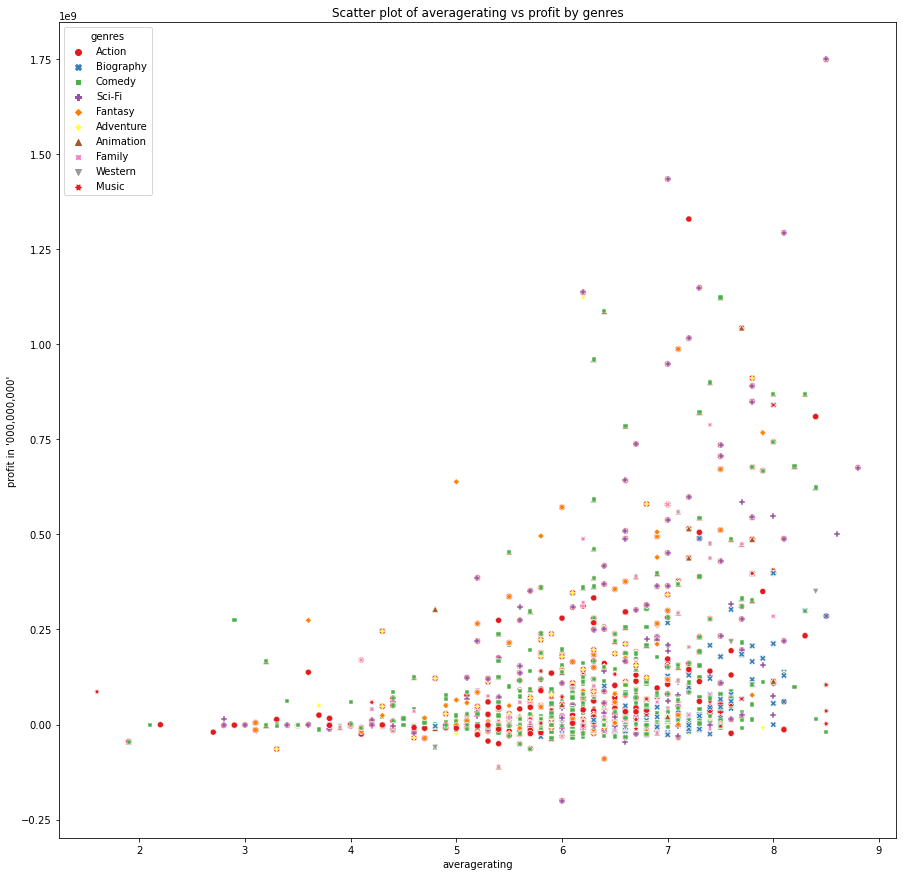

<Figure size 432x288 with 0 Axes>

In [125]:
#Plotting the Scatter Plot
plt.figure(figsize=(15,15))
#creates a scatter plot
sns.scatterplot(data=genres_explode_filtered, x='averagerating', y='profit', hue='genres', style='genres', palette='Set1')

plt.title('Scatter plot of averagerating vs profit by genres')# sets the title of the plot

#set the labels for the x-axis and y-axis
plt.xlabel('averagerating')
plt.ylabel("profit in '000,000,000'")
# displays the plot to the screen
plt.show()
#Saving the Plot as an Image
plt.savefig('Average_rating_vs_profit_by_genres.png') 


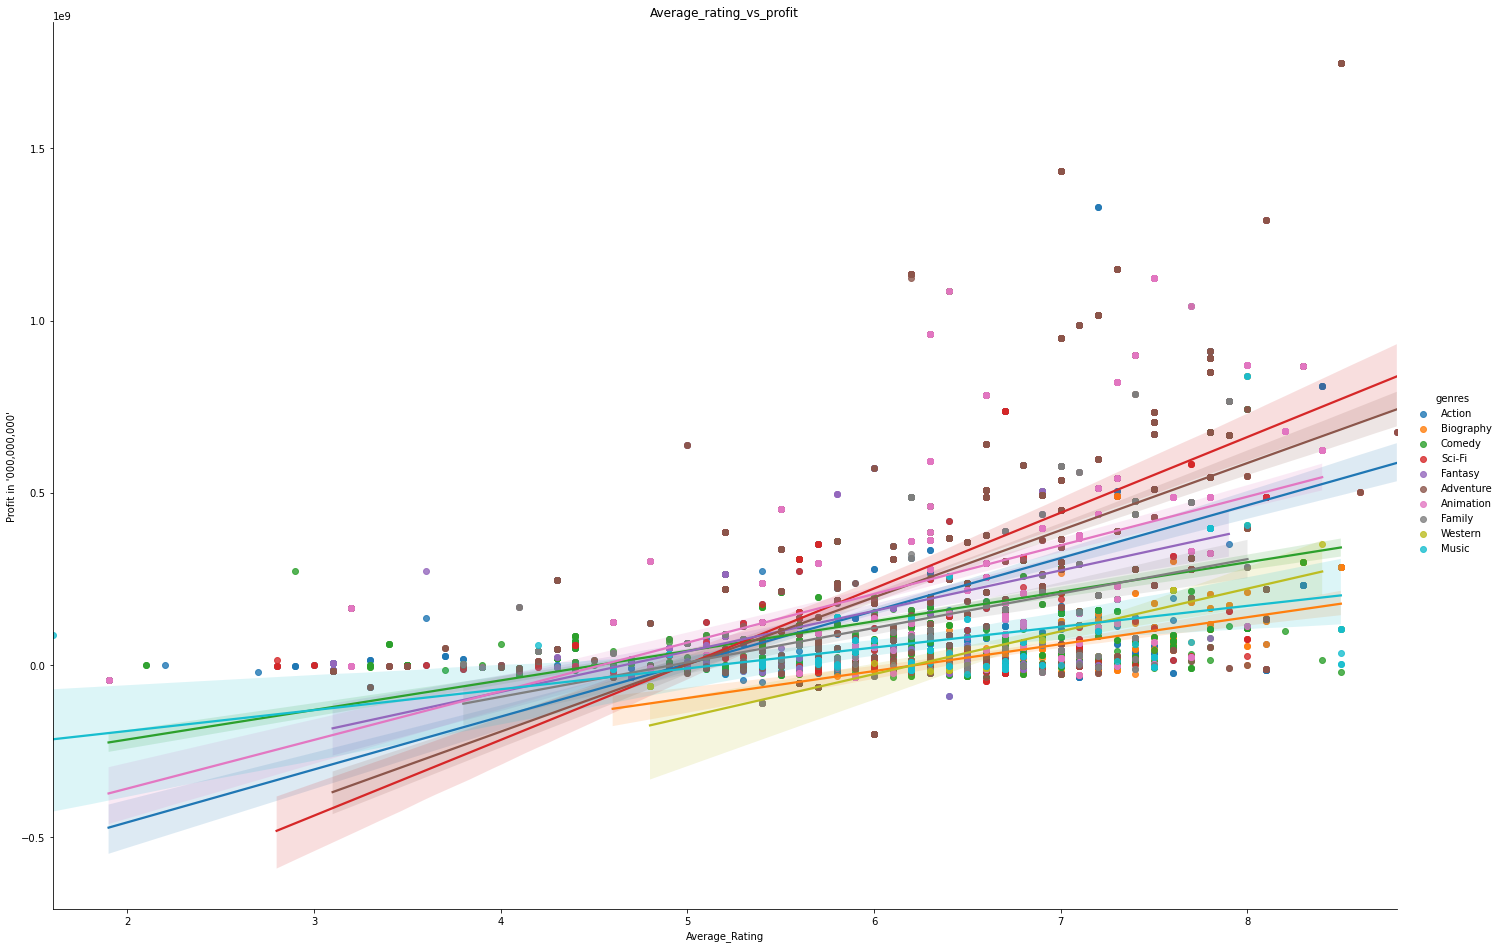

<Figure size 432x288 with 0 Axes>

In [126]:

sns.lmplot(x='averagerating', y='profit', data=genres_explode_filtered, hue='genres', aspect=1.5, height=13)
plt.title('Average_rating_vs_profit')#Labels the plot
plt.xlabel('Average_Rating') #labels the x axis
plt.ylabel("Profit in '000,000,000'") #Labels the y axis
plt.show()

plt.savefig('Average_rating_vs_profitAgainst_genres') #Saves an image of the plot

From the above visuals we can conclude there is a general increase in profit with an increase in average rating in the different genres.

#### Modeling the profit by genre and average rating.

From our univariate analysis we saw profit and average rating are not normally distributed so we begin with log transformation

In [127]:
# Apply log transformation to profit (in billions) to deal with skewness
genres_explode_filtered['log_profit'] = np.log1p(genres_explode_filtered['profit'])

# Apply log or other transformation to average rating 
genres_explode_filtered['log_averagerating'] = np.log1p(genres_explode_filtered['averagerating'])  



c:\Users\Administrator\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-127-e52883bbf78a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_explode_filtered['log_profit'] = np.log1p(genres_explode_filtered['profit'])
<ipython-input-127-e52883bbf78a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_explode_filtered['log_averagerating'] = np.log1p(genres_expl

In [128]:
# Replace NaN values with a custom value ( 0)
genres_explode_filtered['log_profit'].fillna(0, inplace=True)
genres_explode_filtered['log_averagerating'].fillna(0, inplace=True)

# Replace NaN values in categorical column with 'Unknown'
genres_explode_filtered['genres'].fillna('Unknown', inplace=True)
genres_explode_filtered['primary_name'].fillna('Unknown', inplace=True)



c:\Users\Administrator\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Model the data using multiple linear regression.

In [129]:

# Perform one-hot encoding for the 'genre' column to convert categorical variable into numerical
genres_dummies = pd.get_dummies(genres_explode_filtered['genres'], drop_first=True)  # drop_first to avoid dummy variable trap

# Define the independent variables (X) and dependent variable (y)
X = pd.concat([genres_explode_filtered['log_averagerating'], genres_dummies], axis=1)
y = genres_explode_filtered['log_profit']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the multiple linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Display the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_profit   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     141.6
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          1.48e-270
Time:                        05:24:07   Log-Likelihood:                -22873.
No. Observations:                6868   AIC:                         4.577e+04
Df Residuals:                    6857   BIC:                         4.584e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -18.9751      0.98

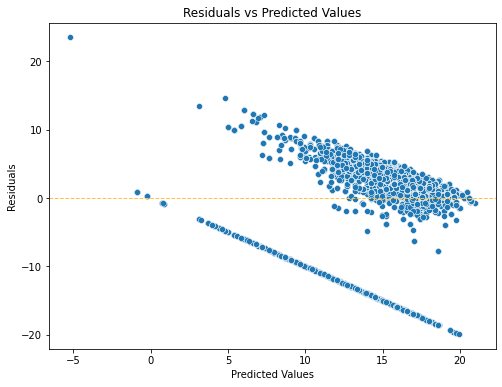

In [131]:
# Get the predicted values (y_hat)
y_pred_mlg = model.predict(X)

# Calculate the residuals
residuals_mlg = y - y_pred_mlg

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_mlg, y=residuals_mlg)
plt.axhline(0, color='#FFC145', linestyle='--', linewidth=1)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()



In [132]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_test_stat, bp_test_p_value, _, _ = bp_test

print(f'Breusch-Pagan Test Statistic: {bp_test_stat}')
print(f'Breusch-Pagan p-value: {bp_test_p_value}')

Breusch-Pagan Test Statistic: 307.5041621521241
Breusch-Pagan p-value: 4.0249834303071686e-60


##### Insight

1. The test statistic (307.5041621521241) is quite large, suggesting the presence of heteroscedasticity.
2. The p-value is extremely small (4.0249834303071686e-60), which is much less than the common significance level of 0.05.
3. Since the p-value is less than 0.05, we reject the null hypothesis. The null hypothesis in the Breusch-Pagan test is that there is no heteroscedasticity (constant variance of the residuals). Therefore, we conclude that there is heteroscedasticity in the residuals, meaning the variance of the errors is not constant across the levels of the independent variables.

In [134]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R-squared
mse = mean_squared_error(y, y_pred_mlg)
r2 = r2_score(y, y_pred_mlg)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 45.739244348378335
R-squared: 0.17116183720022016


##### Insight

1. Mean Squared Error (MSE): 45.739244348378335
MSE is a measure of the average squared difference between the actual values (y) and the predicted values (y_pred).
The value of 45.739244348378335 indicates how far off your model’s predictions are from the true values, on average. Lower MSE values generally suggest better model performance, while higher values indicate greater prediction errors.
2. R-squared: 0.17116183720022016
R-squared (also known as the coefficient of determination) represents the proportion of the variance in the dependent variable (y) that is explained by the independent variables (X) in the model.
R-squared = 0.17116183720022016 indicates that approximately 17% of the variability in the dependent variable (e.g., log_profit) is explained by the independent variables (e.g., log_averagerating, genres).
This value is relatively low, suggesting that the model is not explaining a large portion of the variability in the dependent variable. This could indicate that either:
The relationship between the predictors and the dependent variable is weak.
There are other important predictors that are missing from the model.
The model may need refinement or more complex approaches to improve the fit.

Model the data using Extreme Gradient Boosting model.

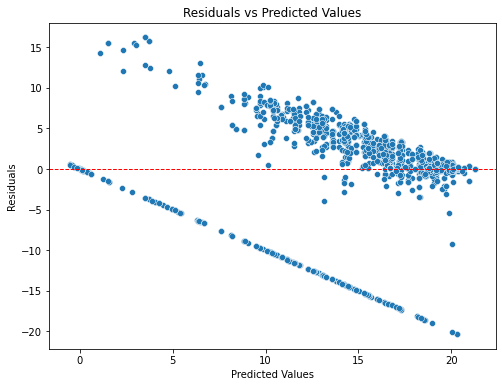

In [135]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define independent variables (X) and dependent variable (y)
X = pd.concat([genres_explode_filtered['log_averagerating'], pd.get_dummies(genres_explode_filtered['genres'], drop_first=True)], axis=1)
y = genres_explode_filtered['log_profit']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()




In [136]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 38.96673241472954
R-squared: 0.29636506903395643


##### Insight

1. Mean Squared Error (MSE): 38.96673241472954
MSE measures the average squared difference between the actual and predicted values.
A value of 38.96673241472954 shows the magnitude of prediction errors. While lower than your previous model’s MSE (i.e, 45.739244348378335), this value still suggests room for improvement.
2. R-squared: 0.29636506903395643
R-squared represents the proportion of variance in the target variable (log_profit) explained by the independent variables (e.g., log_average_rating and genres).
R-squared = 0.29636506903395643 means that 26.11% of the variance in log_profit is explained by the model, which is an improvement over the previous linear model (R-squared = 0.17).

To improve the model we can add an independent variable ie directors.

#### Profit relationship with genre, average rating  and directors

Goals:
1. Visualize profit by directors and genres using heat map.
2. Model the profit using average rating, directors and genres 

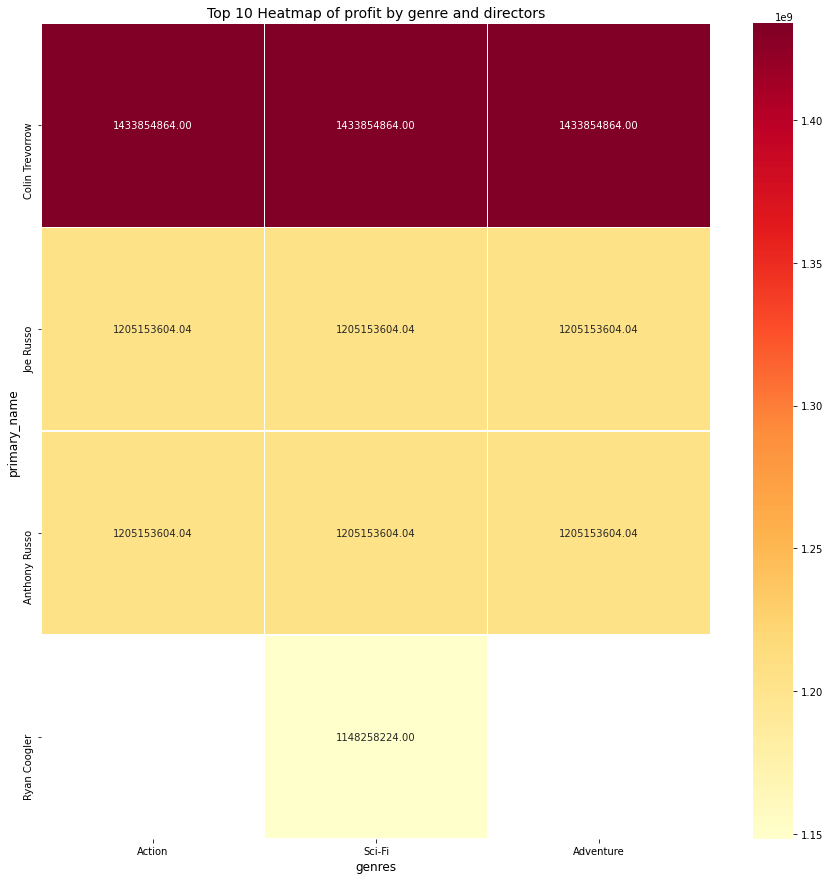

<Figure size 432x288 with 0 Axes>

In [140]:
# Aggregating the 'numeric_value' by 'category1' and 'category2'
pivot_df = genres_explode_filtered.pivot_table(values='profit', 
                          index='primary_name', 
                          columns='genres', 
                          aggfunc='mean')  # You can also use 'sum', 'count', 'median', etc.

# Filter the top 10 combinations based on the sum of numeric_value
top_10_df = pivot_df.stack().sort_values(ascending=False).head(10).unstack()

# Create the heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(top_10_df, annot=True, cmap="YlOrRd", fmt='.2f', linewidths=.5, ax=ax)

# Add title and labels
ax.set_title('Top 10 Heatmap of profit by genre and directors', fontsize=14)
plt.xlabel('genres', fontsize=12)
plt.ylabel('primary_name', fontsize=12)

# Show the plot
plt.show()

plt.savefig('Top 10 Heatmap of profit by genre and directors') #Saves an image of the figure

This shows correlation matrices, showing the strength of relationships between pairs of variables. The color intensity or gradient allows you to quickly assess which variables are positively or negatively correlated.

In [142]:
# Perform one-hot encoding for the 'genre' column
genres_dummies = pd.get_dummies(genres_explode_filtered['genres'], drop_first=True)

# Perform one-hot encoding for the 'primary_name' column
primary_name_dummies = pd.get_dummies(genres_explode_filtered['primary_name'], drop_first=True)

# Define the independent variables (X) and dependent variable (y)
X = pd.concat([genres_explode_filtered['log_averagerating'], genres_dummies, primary_name_dummies], axis=1)
y = genres_explode_filtered['log_profit']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the multiple linear regression model using statsmodels
model2 = sm.OLS(y, X).fit()

# Display the model summary
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:             log_profit   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     41.43
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        05:39:38   Log-Likelihood:                -16393.
No. Observations:                6868   AIC:                         3.476e+04
Df Residuals:                    5879   BIC:                         4.152e+04
Df Model:                         988                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

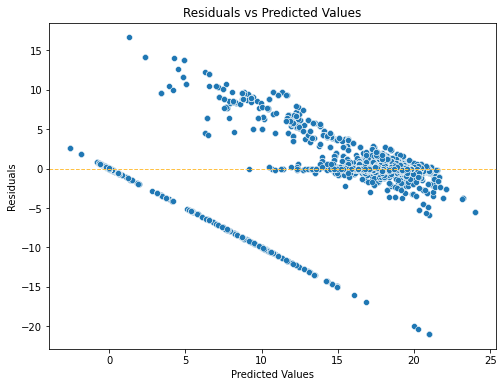

In [143]:
# Get the predicted values (y_hat)
y_pred_mlg2 = model2.predict(X)

# Calculate the residuals
residuals_mlg2 = y - y_pred_mlg2

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_mlg2, y=residuals_mlg2)
plt.axhline(0, color='#FFC145', linestyle='--', linewidth=1)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [144]:
# Calculate R-squared (R²) and Mean Squared Error (MSE)
y_pred = model2.predict(X)  # Predicted values
residuals = y - y_pred  # Residuals

# R-squared (R²)
r2 = model2.rsquared
print(f'R-squared: {r2}')

# Mean Squared Error (MSE)
mse = np.mean(residuals**2)
print(f'Mean Squared Error: {mse}')


R-squared: 0.8744068118953834
Mean Squared Error: 6.930831345656315


#### Insights

1. R-squared: 0.8744068118953834: Approximately 87.4% of the variance in the dependent variable (log-transformed profit) is explained by the independent variables (including log_averagerating, genres, and primary_name). This is a strong indication that your model fits the data well.
2. Mean Squared Error (MSE): 6.9308313456563155: The MSE represents the average squared difference between the actual and predicted values of log_profit. A lower MSE value indicates a better fit. Since MSE is on the log scale, it reflects the prediction error on the log-transformed profit.

In [146]:
#Generate model coefficients
coefficients = model2.params
coefficients

const               -27.624314
log_averagerating    14.039463
Adventure             0.349527
Animation             0.520729
Biography            -0.811740
                       ...    
Zach Braff           11.957807
Zack Snyder          18.541451
Zal Batmanglij       -1.564007
Zhengyu Lu           18.244354
Zhigang Yang         15.149180
Length: 989, dtype: float64

# Conclusion and Recommendations 


Are there specific themes, formats (e.g., sequels, franchises), or release periods that contribute to a film's success?
How do production budgets correlate with box office returns?
What are the demographic trends (age, region, preferences) of the movie-going audience?
What role do critical reviews and audience ratings play in a film's financial performance?

## Most successful genres at the box office 

### Conclusions


From our analysis, we deduced that the top performing genres are:
1. Sci-Fi with $316,263,600 profit on average
2. Adventure with $295,017,400 profit on average
3. Animation with $284,940,600 profit on average
4. Action with $201,383,700 profit on average
5. Fantasy with $161,772,500 profit on average
6. Comedy with $121,160,100 profit on average
7. Family with $105,058,080 profit on average
8. Music with $66,521,440 profit on average
9. Western with $65,964,350 profit on average
10. Biography with $65,118,880 profit on average

We can see these genres have high profit output on average.

From the Kruskal-Wallis H Test we can conclude that the observed differences in profits across genres are statistically significant therefore genres have an impact on profit.



### Recommendations


1. Focus on High-Performing Genres for Investment: We should  prioritize investments in Sci-Fi, Adventure, Animation, and Action genres as these have proven to generate the highest average profits at the box office. Allocating more resources and marketing efforts into these genres can increase the chances of a successful film.
2. Leverage Franchise Potential in Sci-Fi and Adventure: Genres like Sci-Fi and Adventure are not only profitable but often lend themselves to creating franchises or sequels that can generate sustained revenue.
3. Diversify Portfolio by Exploring Animation and Family Films: The Animation and Family genres have demonstrated strong profitability with a wide and diverse audience base, often appealing to children and families.
4. Understand Emerging Trends in Fantasy and Comedy: Fantasy and Comedy genres continue to be profitable, but they may require a more niche, targeted approach due to changing tastes and trends in entertainment.
5. Monitor Western and Biography Genre Growth: While Western and Biography genres show relatively lower average profits, there is still room for growth, especially with unique and compelling storylines.


## Critical reviews and audience ratings play in a film's financial performance   

### Conclusion

From our above analysis we can conclude there is a general increase in profit with an increase in average rating. We also found that there is sufficient evidence to conclude that there is a significant linear relationship between the two variables. This means that the relationship is statistically significant, and changes in one variable are associated with changes in the other variable.

### Recommendation

1. Focus on Improving Film Quality for Higher Ratings: Since films with higher average ratings tend to have higher profits, it’s essential for film studios to prioritize quality in both storytelling and production to ensure higher ratings.
2. Leverage Audience Feedback for Continuous Improvement: Regularly analyze audience feedback and reviews to improve the quality of films.
3. Incorporate Audience Preferences into Film Development: If higher ratings are strongly associated with higher profits, producers should aim to incorporate popular themes and genres that resonate well with audiences.
4. Invest in Professional Film Reviewers and Critics: Since film ratings, especially from critics, influence box office performance, collaborating with respected film critics and reviewers can help improve a film’s visibility and ratings.
5. Promote Films Based on Rating Milestones: Marketing efforts can be boosted by highlighting positive ratings in promotional material.


## Director influence on film success

### Conclusion

From this we can conclude that the top 10  directors by average profit earned are:
1. Anthony Russo with $1,205,154,000 average profit
2. Joe Russo with $1,205,154,000 average profit
3. Colin Trevorrow with $1,195,491,000 average profit
4. Adam Green with $1,122,470,000 average profit
5. Chris Buck with $1,122,470,000 average profit
6. Kyle Balda with $1,001,931,000 average profit
7. Anna Boden with $948,061,600 average profit
8. Ryan Fleck with $948,061,600 average profit
9. James Wan with $843,016,808 average profit
10. Pierre Coffin  with $778,452,400 average profit

There is overwhelming evidence to conclude that profits significantly differ among directors therefore directors have a significant impact on a film making profit.

### Recommendation

1. Collaborate with Proven Directors for Maximum Profit: Given that directors like Anthony Russo and Joe Russo have consistently produced films with high profits, studios should prioritize working with established directors known for their successful track records.
2. Leverage Director’s Fanbase and Reputation: Directors like James Wan and Colin Trevorrow have built substantial fanbases, which helps drive the box office success of their films.
3. Analyze Director Trends and Preferences: Understand the creative preferences and strengths of top directors to predict what types of films are more likely to succeed.
4. Provide Creative Freedom for Established Directors:: Directors like Joe Russo and Anthony Russo thrive when given the creative freedom to execute their vision.


## Profit given director, genre and critic rating

### Conclusion

Based on our analysis, we have successfully built a predictive model that is 87% accurate in forecasting Profit using key features such as Director Name, Genre, and Critic Rating. This high level of accuracy indicates that these factors play a significant role in determining a film's profitability, and our model can be a valuable tool for understanding and predicting the financial success of films in the industry.

### Recommendation

1. Focus on High-Performing Directors: Given the significant impact of director name on profit, studios should prioritize collaborating with successful directors who have a proven track record of creating profitable films. Directors like Anthony Russo and Joe Russo, who are at the top of the list, should be considered for future high-budget productions.

2. Invest in Profitable Genres: The model highlights certain genres, such as Sci-Fi and Adventure, which are associated with higher profitability. Studios should consider focusing more on these genres, as they tend to generate higher returns at the box office. Exploring emerging trends within these genres or creating sequels and franchises could also enhance profitability.

3. Enhance Film Quality to Improve Critic Ratings: Since Critic Ratings have a noticeable effect on profitability, studios should focus on improving the quality of films in ways that appeal to critics. This could involve refining the script, investing in high-quality production, or assembling a strong cast. A positive critical reception not only attracts wider audiences but also improves the overall perception of the film, which can lead to increased box-office revenue.

4. Tailor Marketing Strategies Based on Predictive Insights: With the model's ability to predict profit based on key features, studios can tailor their marketing strategies to emphasize the strengths of a film. For example, if a film features a top-tier director or belongs to a high-performing genre, marketing campaigns can be designed to capitalize on these elements to generate more buzz and attract a larger audience.

5. Optimize Resource Allocation: The model provides valuable insights into the relationship between various features (e.g., director, genre, critic rating) and profitability. Studios can use this information to allocate resources more effectively, ensuring that higher budgets are directed towards projects with higher potential for success, while lower budgets can be invested in projects with potentially more niche audiences.